In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/decomposed")

In [3]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 260


In [4]:
# from datetime import datetime

# dts = [datetime.fromtimestamp(int(x)) for x in folders]
# print(max(dts))
# print(min(dts))

In [5]:
from tddl.post_processing.path_utils import logdir_to_paths

paths = logdir_to_paths(logdir)

print(len(paths))

260


In [6]:
# baseline

baseline_path = Path("/bigdata/cifar10/logs/baselines/1646668631/rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue")
# baseline_model = torch.load(baseline_path / "cnn_best.pth")
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)
baseline_result

{'best_epoch': 229,
 'best_train_acc': 0.9999333333333333,
 'best_valid_acc': 0.9216,
 'best_valid_loss': 0.005079200401902199,
 'test_acc': 0.9137,
 'test_loss': 0.005285387974977494,
 'n_param': 11173962,
 'model_name': 'rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue'}

In [7]:
from tddl.post_processing.factorized_model import process_factorized_networks

# process_factorized_networks(paths, baseline_path)

/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [8]:
from tddl.post_processing.path_utils import paths_to_df

df = paths_to_df(paths)
print(len(df))
df.head()


260


,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
0,conv2,63,0.311843,0.000023,54.784103,63,cp,0.1,0.9210,0.9216,9050765,0.9143,0.00001,adam,12.214946,429.339663,2048.0,0.028521,0.005964
1,conv1,60,0.337100,0.000027,62.611729,60,tucker,0.1,0.9206,0.9216,9051469,0.9137,0.00001,adam,75.989307,2603.942812,2048.0,0.029340,0.037104
2,conv1,60,0.272814,0.000021,50.671532,60,tucker,0.25,0.9210,0.9216,9402829,0.9148,0.00001,adam,47.516211,2603.942812,2048.0,0.018346,0.023201
3,conv1,28,0.823151,0.000408,60.229858,28,tucker,0.1,0.9018,0.8690,11041517,0.8974,0.00001,adam,388.085709,815.280181,8192.0,0.476089,0.047374
4,conv1,28,0.305965,0.000152,22.387421,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,0.00001,adam,105.363881,815.280181,8192.0,0.129281,0.012862


In [9]:
# df.groupby('rank').count()
# rank=0.90: 10 observations
# rank=0.75: 10 observstions

# Exclude the few observations (layer=28, decomp={cp,tucker}) where rank is 0.75 or 0.90

df = df[~df['rank'].isin(['0.75', '0.90'])]

In [10]:
df['test_error'] = 1 - df.test_acc
df['valid_error_before_ft'] = 1 - df.valid_acc_before_ft
df['valid_error'] = 1 - df.valid_acc

df['log_test_error'] = np.log(df.test_error)
df['log_valid_error_before_ft'] = np.log(df.valid_error_before_ft)
df['log_valid_error'] = np.log(df.valid_error)

In [11]:
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df['layers_fact'] = df['layers'].apply(str) + '-' + df['factorization'] 
df.head()

,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,...,scaled_norm,test_error,valid_error_before_ft,valid_error,log_test_error,log_valid_error_before_ft,log_valid_error,fact_rank,fact_layers,layers_fact
0,conv2,63,0.311843,0.000023,54.784103,63,cp,0.10,0.9210,0.9216,...,0.005964,0.0857,0.0784,0.0790,-2.456902,-2.545931,-2.538307,cp-0.1,cp-63,63-cp
1,conv1,60,0.337100,0.000027,62.611729,60,tucker,0.10,0.9206,0.9216,...,0.037104,0.0863,0.0784,0.0794,-2.449926,-2.545931,-2.533257,tucker-0.1,tucker-60,60-tucker
2,conv1,60,0.272814,0.000021,50.671532,60,tucker,0.25,0.9210,0.9216,...,0.023201,0.0852,0.0784,0.0790,-2.462754,-2.545931,-2.538307,tucker-0.25,tucker-60,60-tucker
3,conv1,28,0.823151,0.000408,60.229858,28,tucker,0.10,0.9018,0.8690,...,0.047374,0.1026,0.1310,0.0982,-2.276917,-2.032558,-2.320749,tucker-0.1,tucker-28,28-tucker
5,conv2,63,0.198279,0.000015,34.833344,63,tucker,0.50,0.9210,0.9216,...,0.003005,0.0855,0.0784,0.0790,-2.459239,-2.545931,-2.538307,tucker-0.5,tucker-63,63-tucker


In [12]:
df = df.astype({
    'layers':"category",
    'fact_layers':"category",
    'layers_fact':"category",
})

## Approximation error on the weights

In [13]:
df_rank = df.set_index('rank', inplace=False)

In [15]:
grouped_df = df_rank.groupby('factorization')
ax = grouped_df['error'].plot(legend=True, style=".", ylabel='relative approximation error on weights', xlabel='relative rank')

KeyError: 'Column not found: error'

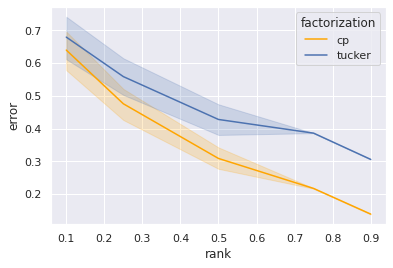

In [16]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
ax = sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

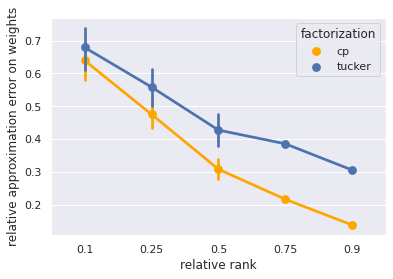

In [17]:
ax = sns.pointplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.set(xlabel='relative rank', ylabel='relative approximation error on weights')

[(0.865, 0.925)]

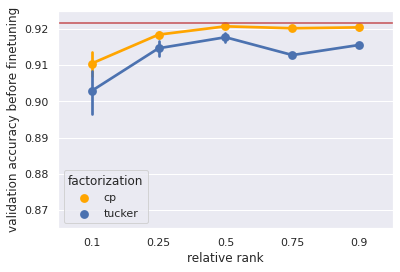

In [18]:
ax = sns.pointplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative rank', ylabel='validation accuracy before finetuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

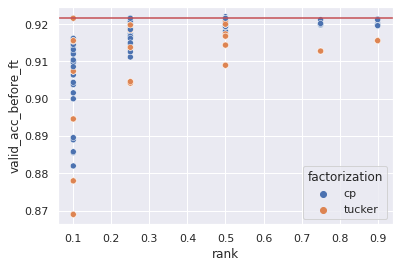

In [19]:
ax = sns.scatterplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="factorization",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

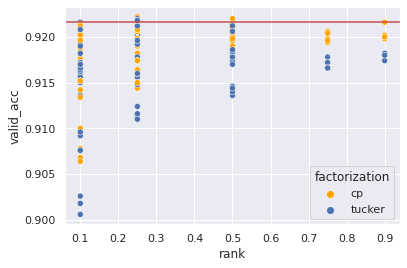

In [20]:
ax = sns.scatterplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

[(0.865, 0.925)]

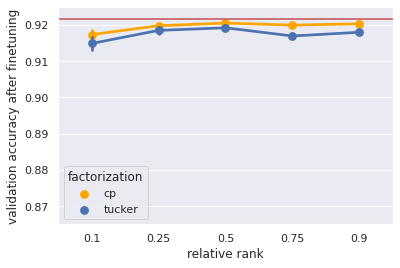

In [21]:
ax = sns.pointplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='validation accuracy after finetuning')
ax.set(ylim=(0.865, 0.925))

[Text(0.5, 0, 'relative rank'), Text(0, 0.5, 'test accuracy after finetuning')]

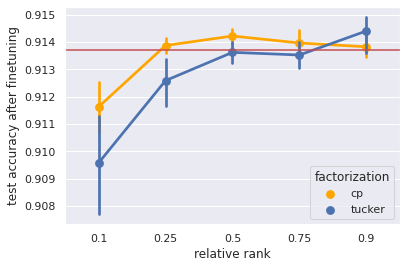

In [22]:
ax = sns.pointplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='test accuracy after finetuning')
# ax.set(ylim=(0.865, 0.925))

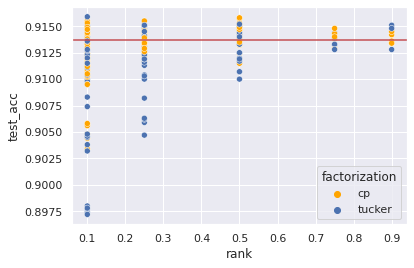

In [23]:
ax = sns.scatterplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['test_acc'], color='r')

In [24]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

In [25]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

[(0.865, 0.925)]

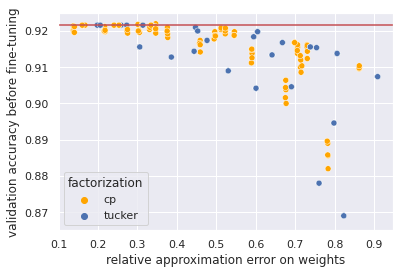

In [26]:
ax = sns.scatterplot(
    x="error", y="valid_acc_before_ft", 
    hue="factorization", 
    # style="factorization",
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy before fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

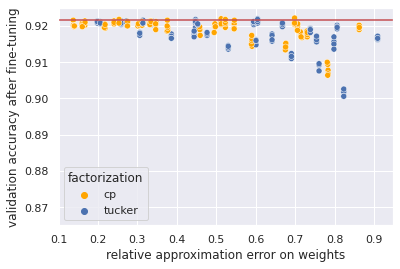

In [27]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

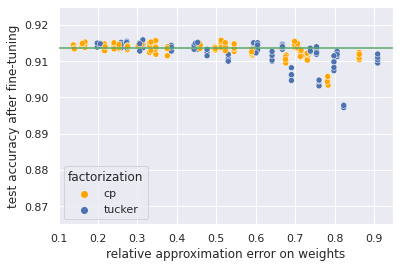

In [28]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

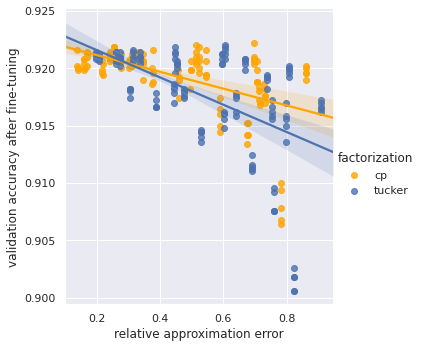

In [29]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g = g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')


In [30]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact
0,conv2,63,0.311843,63,cp,0.10,0.9210,0.9216,9050765,0.9143,0.00001,adam,12.214946,429.339663,2048.0,0.028521,0.005964,cp-0.1,cp-63,63-cp
1,conv1,60,0.337100,60,tucker,0.10,0.9206,0.9216,9051469,0.9137,0.00001,adam,75.989307,2603.942812,2048.0,0.029340,0.037104,tucker-0.1,tucker-60,60-tucker
2,conv1,60,0.272814,60,tucker,0.25,0.9210,0.9216,9402829,0.9148,0.00001,adam,47.516211,2603.942812,2048.0,0.018346,0.023201,tucker-0.25,tucker-60,60-tucker
3,conv1,28,0.823151,28,tucker,0.10,0.9018,0.8690,11041517,0.8974,0.00001,adam,388.085709,815.280181,8192.0,0.476089,0.047374,tucker-0.1,tucker-28,28-tucker
4,conv1,28,0.305965,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,0.00001,adam,105.363881,815.280181,8192.0,0.129281,0.012862,tucker-0.9,tucker-28,28-tucker


In [31]:
# g = sns.lmplot(x="error", y="test_acc", 
#    hue="fact_rank", 
#    data=df,
#    truncate=False, 
#    # palette=['orange','b'],
# )
# g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
# g.set(ylim=(0.935, 0.945))

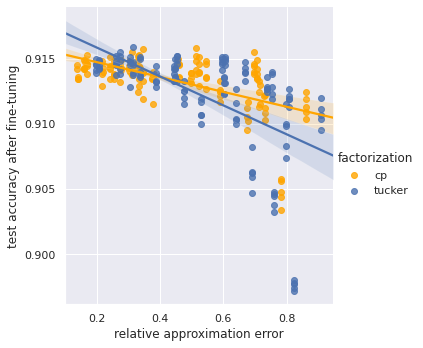

In [32]:
ax = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   # logistic=True,
   truncate=False, 
   palette=['orange','b'],
)
ax.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')


In [33]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

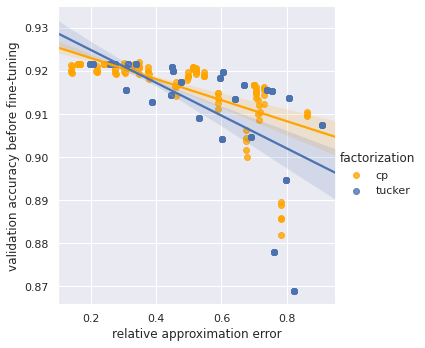

In [34]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [35]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
5,conv2,63,0.198279,63,tucker,0.5,0.9210,0.9216,9997024,0.9145,0.00001,adam,6.153332,429.339663,2048.0,0.014415,0.003005
9,conv2,15,0.304725,15,cp,0.5,0.9206,0.9198,11155728,0.9140,0.00001,adam,47.736296,545.957711,16384.0,0.087451,0.002914
12,conv2,38,0.346829,38,cp,0.5,0.9212,0.9208,10879449,0.9119,0.00001,adam,54.038538,420.262521,4096.0,0.128686,0.013193
22,conv2,15,0.301261,15,cp,0.5,0.9200,0.9218,11155728,0.9141,0.00001,adam,47.295244,545.957711,16384.0,0.086648,0.002887
26,conv1,28,0.375088,28,cp,0.5,0.9186,0.9198,11100409,0.9134,0.00001,adam,110.821921,815.280181,8192.0,0.135994,0.013528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,conv2,63,0.160493,63,cp,0.5,0.9200,0.9216,9995161,0.9147,0.00001,adam,4.984808,429.339663,2048.0,0.011677,0.002434
251,conv1,60,0.167152,60,cp,0.5,0.9210,0.9216,9995161,0.9153,0.00001,adam,20.135873,2603.942812,2048.0,0.007780,0.009832
255,conv1,44,0.447319,44,tucker,0.5,0.9212,0.9210,10879741,0.9150,0.00001,adam,135.603151,726.060440,4096.0,0.186951,0.033106
256,conv2,63,0.160246,63,cp,0.5,0.9198,0.9216,9995161,0.9149,0.00001,adam,4.885679,429.339663,2048.0,0.011455,0.002386


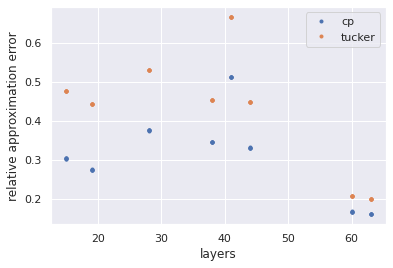

In [36]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
ax = grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

In [37]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

# ax = grouped_df_layers['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

In [38]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

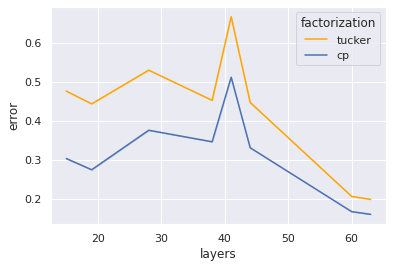

In [39]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
ax = sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             )

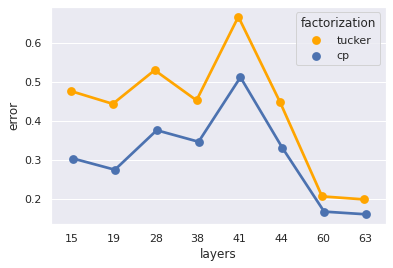

In [40]:
ax = sns.pointplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True
             )

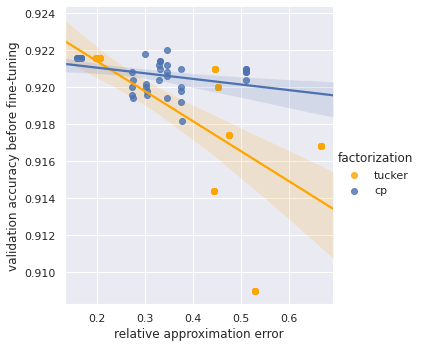

In [41]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

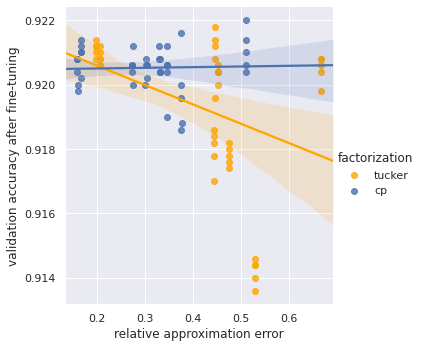

In [42]:
g = sns.lmplot(x="error", y="valid_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

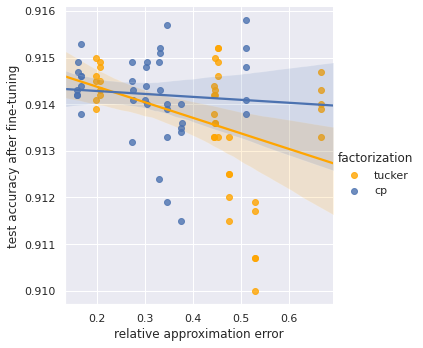

In [43]:
g = sns.lmplot(x="error", y="test_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

[Text(0.5, 0, 'layer number'),
 Text(0, 0.5, 'validation accuracy before fine-tuning')]

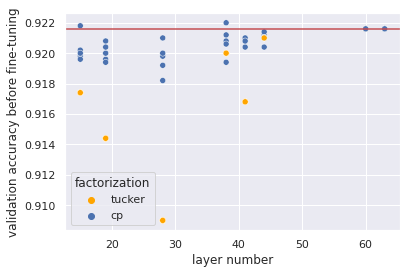

In [44]:
ax = sns.scatterplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    # dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
# ax.set(ylim=(0.908, 0.9220))

[(0.908, 0.922)]

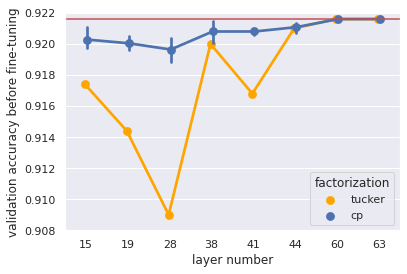

In [45]:
ax = sns.pointplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
ax.set(ylim=(0.908, 0.9220))

[(0.908, 0.922)]

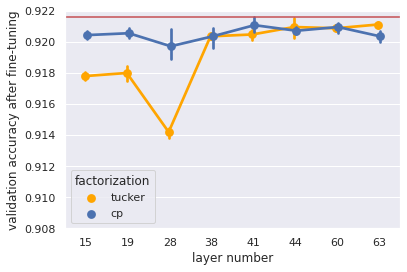

In [46]:
ax = sns.pointplot(x="layers", y="valid_acc",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy after fine-tuning')
ax.set(ylim=(0.908, 0.9220))


[Text(0.5, 0, 'layer number'), Text(0, 0.5, 'test accuracy after fine-tuning')]

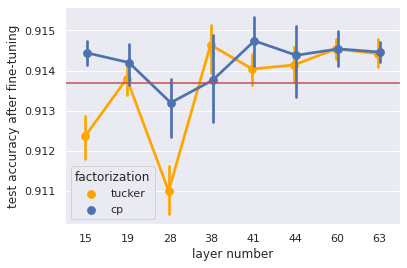

In [47]:
ax = sns.pointplot(x="layers", y="test_acc",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='layer number', ylabel='test accuracy after fine-tuning')

In [48]:
df.factorization.isna()

0      False
1      False
2      False
3      False
4      False
       ...  
255    False
256    False
257    False
258    False
259    False
Name: factorization, Length: 260, dtype: bool

In [49]:
df[df.error.isnull()]

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact


In [50]:
df_layer_rank = df.groupby(['factorization','layers','rank'])
df_std = df_layer_rank[['valid_acc','test_acc']].std()

print(df_std.to_latex())

# df.to_json("/home/jetzeschuurman/gitProjects/phd/tddl/artifacts/f_mnist/std_adam.json")

\begin{tabular}{lllrr}
\toprule
       &    &      &  valid\_acc &  test\_acc \\
factorization & layers & rank &            &           \\
\midrule
cp & 15 & 0.10 &   0.000687 &  0.000886 \\
       &    & 0.25 &   0.000876 &  0.000358 \\
       &    & 0.50 &   0.000329 &  0.000404 \\
       &    & 0.75 &        NaN &       NaN \\
       &    & 0.90 &        NaN &       NaN \\
       & 19 & 0.10 &   0.000767 &  0.000858 \\
       &    & 0.25 &   0.000890 &  0.000658 \\
       &    & 0.50 &   0.000434 &  0.000632 \\
       &    & 0.75 &        NaN &       NaN \\
       &    & 0.90 &        NaN &       NaN \\
       & 28 & 0.10 &   0.001579 &  0.000970 \\
       &    & 0.25 &   0.001178 &  0.000597 \\
       &    & 0.50 &   0.001197 &  0.000977 \\
       &    & 0.75 &   0.000518 &  0.000702 \\
       &    & 0.90 &   0.000729 &  0.000502 \\
       & 38 & 0.10 &   0.000616 &  0.000823 \\
       &    & 0.25 &   0.001033 &  0.000862 \\
       &    & 0.50 &   0.000817 &  0.001370 \\
       &  

## Analysis on the features space

### Relative Norm

[(0.865, 0.925)]

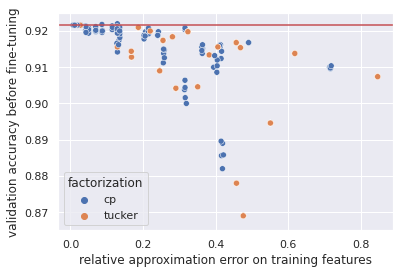

In [51]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
     hue="factorization", 
    # style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

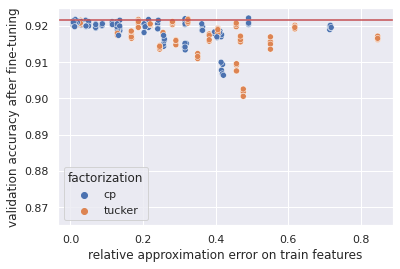

In [52]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
     hue="factorization", 
    # style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

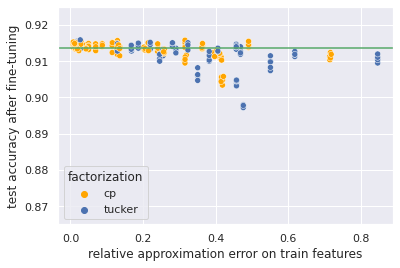

In [53]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

### Scaled Norm

[(0.865, 0.925)]

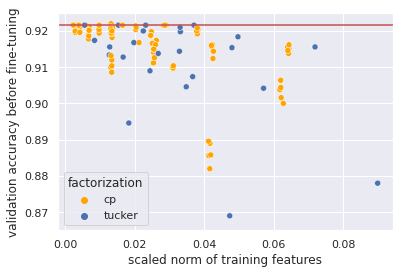

In [54]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

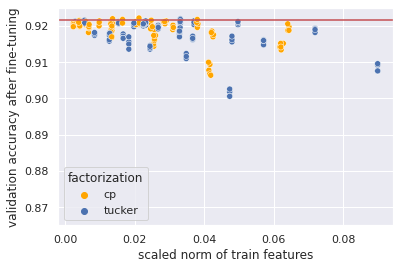

In [55]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

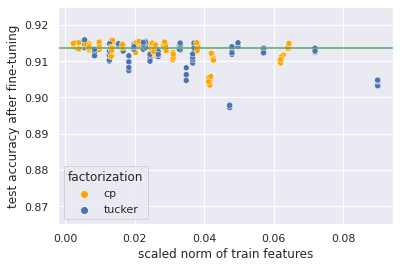

In [56]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

### Absolute Norm

[(0.865, 0.925)]

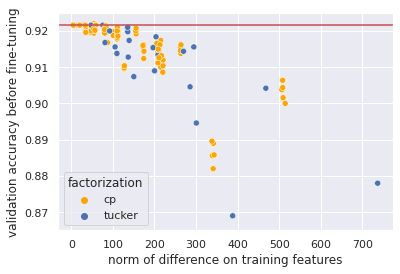

In [57]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='Absolute norm on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

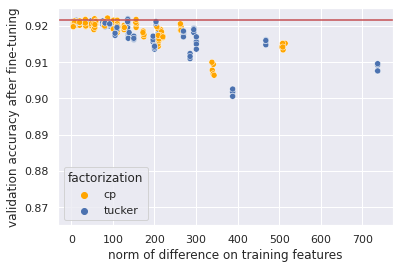

In [58]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='Absolute norm on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

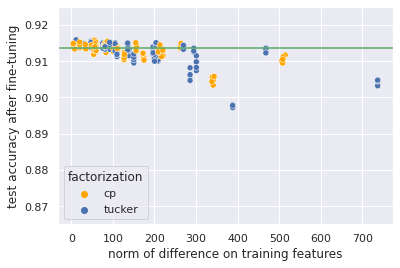

In [59]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='Absolute norm on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

In [60]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

[(0.865, 0.925)]

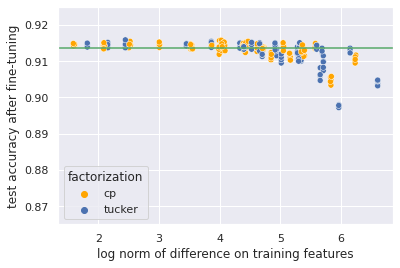

In [61]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(
    xlabel='Log absolute norm on training features', 
    ylabel='Test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

In [62]:
df['log_test_acc'] = np.log(df.test_acc)

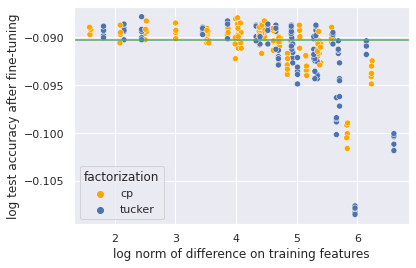

In [63]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(
    xlabel='Log Absolute norm on training features', 
    ylabel='Log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))

# Per Layer

In [13]:
ax = sns.scatterplot(x="error", y="valid_acc_before_ft",
    hue="layers",
    style="factorization",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

ValueError: Could not interpret value `error` for parameter `x`

In [14]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
    
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ValueError: Could not interpret value `error` for parameter `x`

In [ ]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="layers",
    style="factorization", 
    data=df,
    # palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ValueError: Could not interpret value `error` for parameter `x`

## Feature Space

### Relative Norm

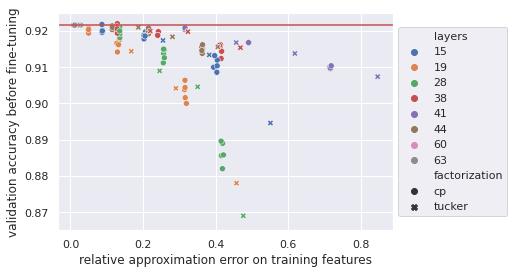

In [15]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

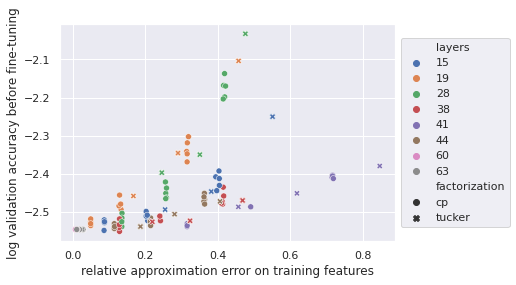

In [16]:
ax = sns.scatterplot(
    x="relative_norm", y="log_valid_error_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='log validation accuracy before fine-tuning'
)
# ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

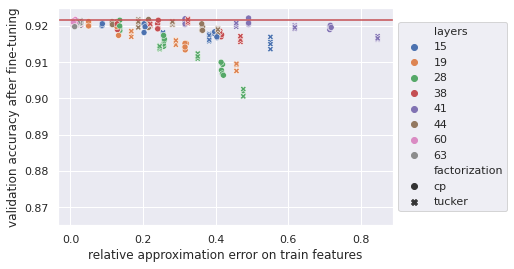

In [17]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

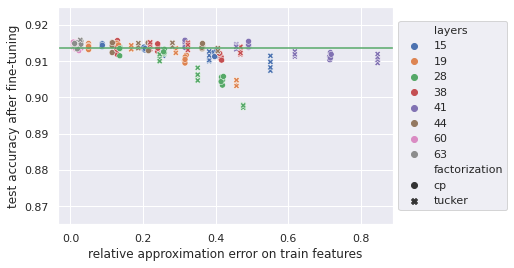

In [18]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Scaled Norm

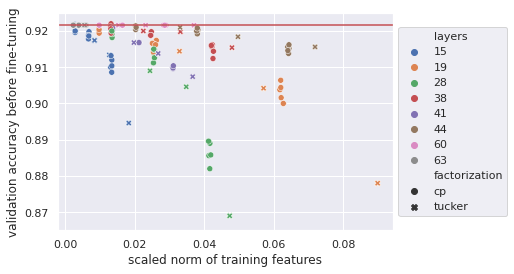

In [19]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

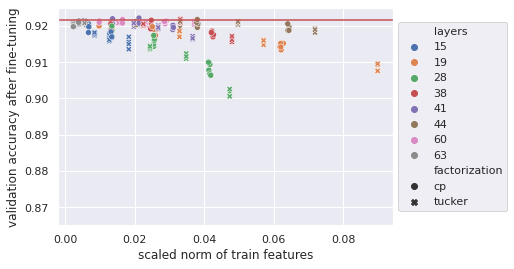

In [20]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

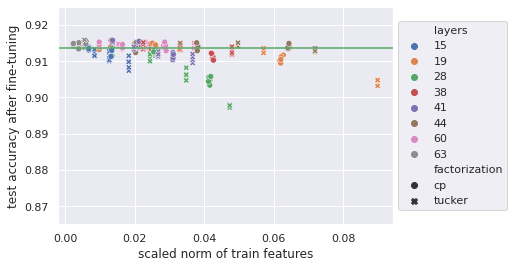

In [21]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Absolute Norm

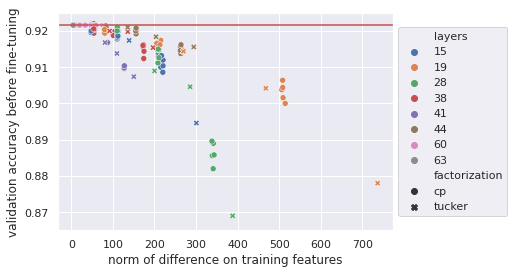

In [22]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='Absolute norm on training features', 
    ylabel='Validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

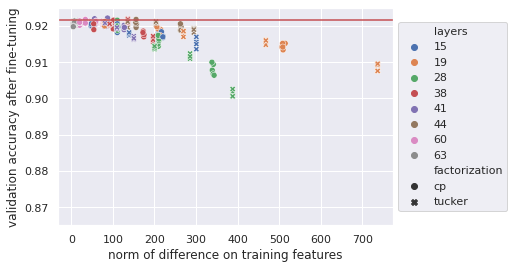

In [23]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='Absolute norm on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

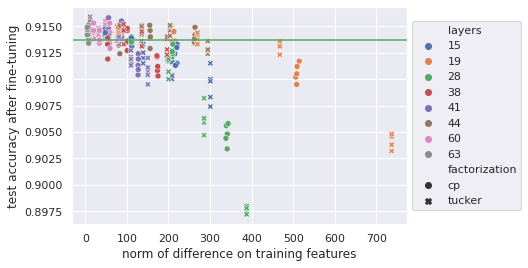

In [24]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='Absolute norm on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [25]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

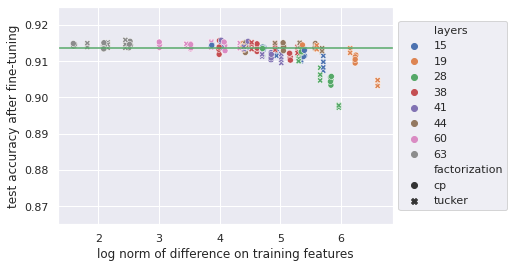

In [26]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='Absolute log norm on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [27]:
df['log_test_acc'] = np.log(df.test_acc)

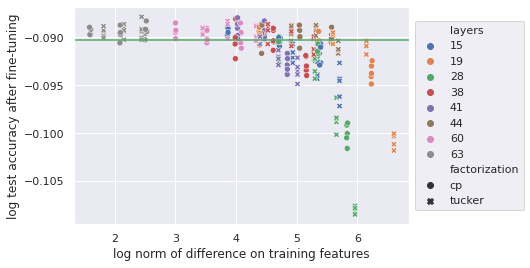

In [28]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='Log Absolute norm on training features', ylabel='Log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

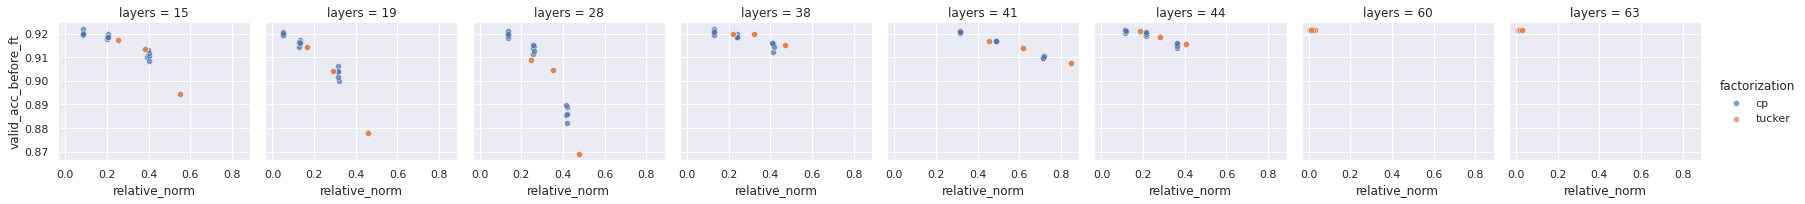

In [29]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc_before_ft", alpha=.7)
g.add_legend()

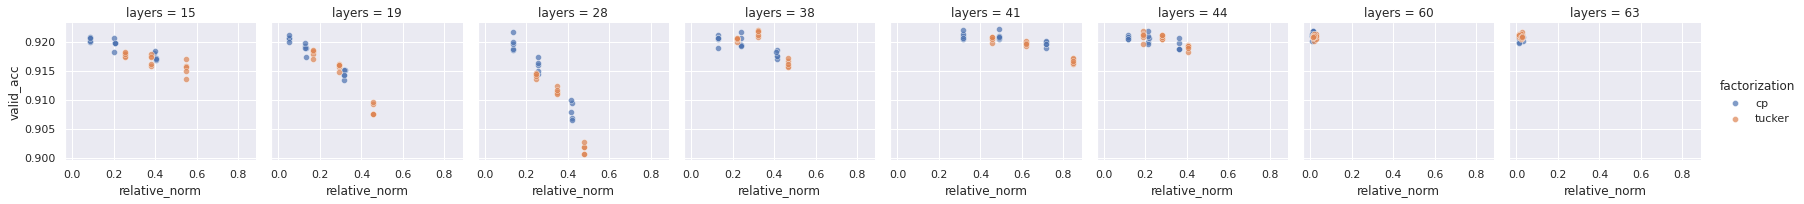

In [30]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc", alpha=.7)
g.add_legend()

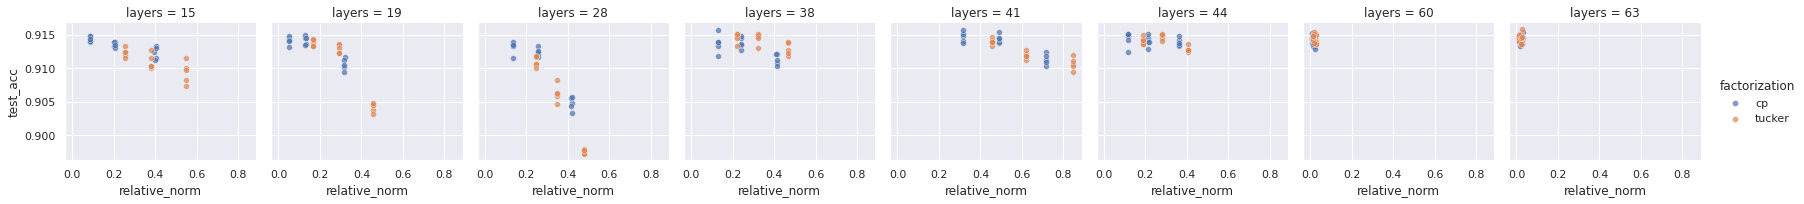

In [31]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "test_acc", alpha=.7)
g.add_legend()
# g.axhline(np.log(baseline_result['test_acc']), color='g')

In [108]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'error': 'Relative norm on weights',
    'relative_norm': 'Relative norm on training features',
    'scaled_norm': 'Scaled norm on training features',
    'norm_diff': 'Absolute norm on training features',
    'log_norm_diff': 'Log absolute norm on training features',
}

KeyError: "['error'] not in index"

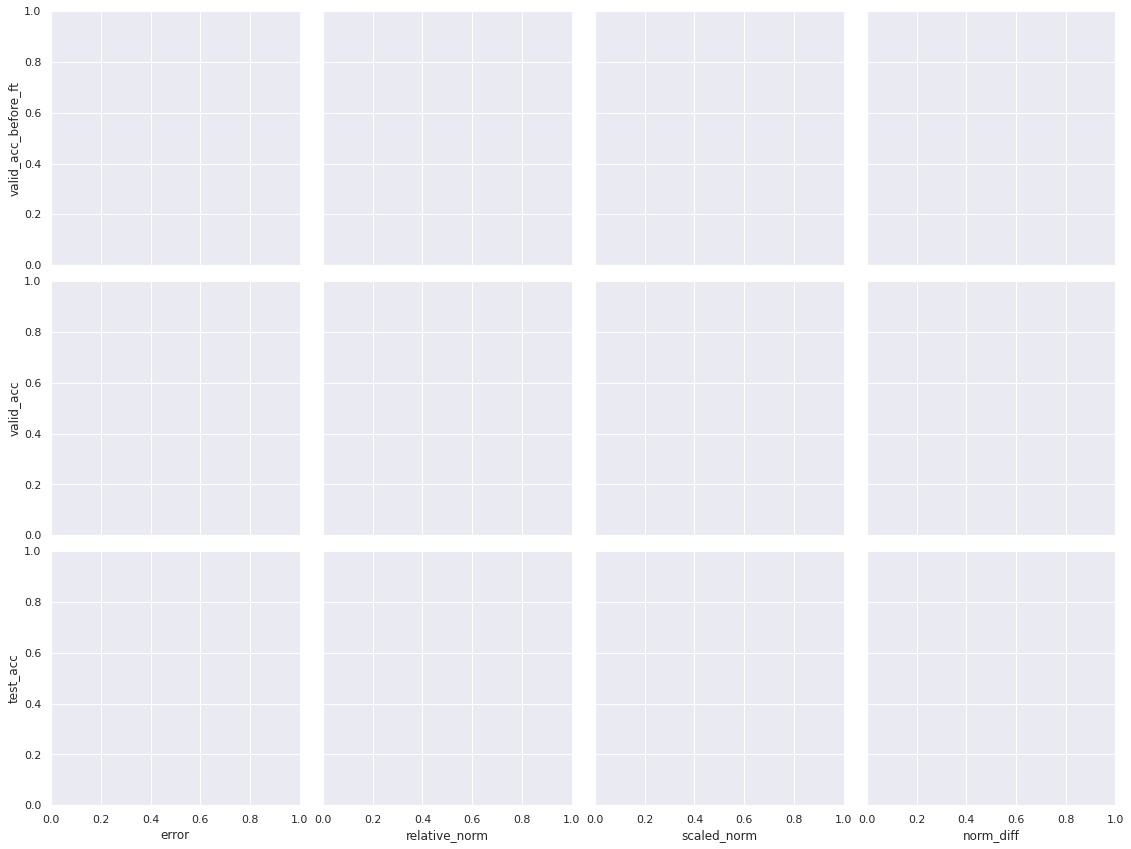

In [109]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])



In [110]:
df.relative_norm

0      0.028521
1      0.029340
2      0.018346
3      0.476089
5      0.014415
         ...   
255    0.186951
256    0.011455
257    0.219677
258    0.550880
259    0.406067
Name: relative_norm, Length: 240, dtype: float64

In [48]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'relative_norm_weight': 'Relative Weights',
    'scaled_norm_weight': 'Scaled Weights',
    'diff_norm_weight': 'Absolute Weights',
    'relative_norm': 'Relative Features',
    'scaled_norm': 'Scaled Features',
    'norm_diff': 'Absolute Features',
    'log_valid_error_before_ft': 'Log Validation error before fine-tuning',
    'log_valid_error': 'Log Validation error after fine-tuning',
    'log_test_error': 'Log Test error after fine-tuning',
    'valid_error_before_ft': 'Validation error before fine-tuning',
    'valid_error': 'Validation error after fine-tuning',
    'test_error': 'Test error after fine-tuning'
    # 'log_norm_diff': 'Log absolute norm between training features',
}

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7ff4b74e7eb0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


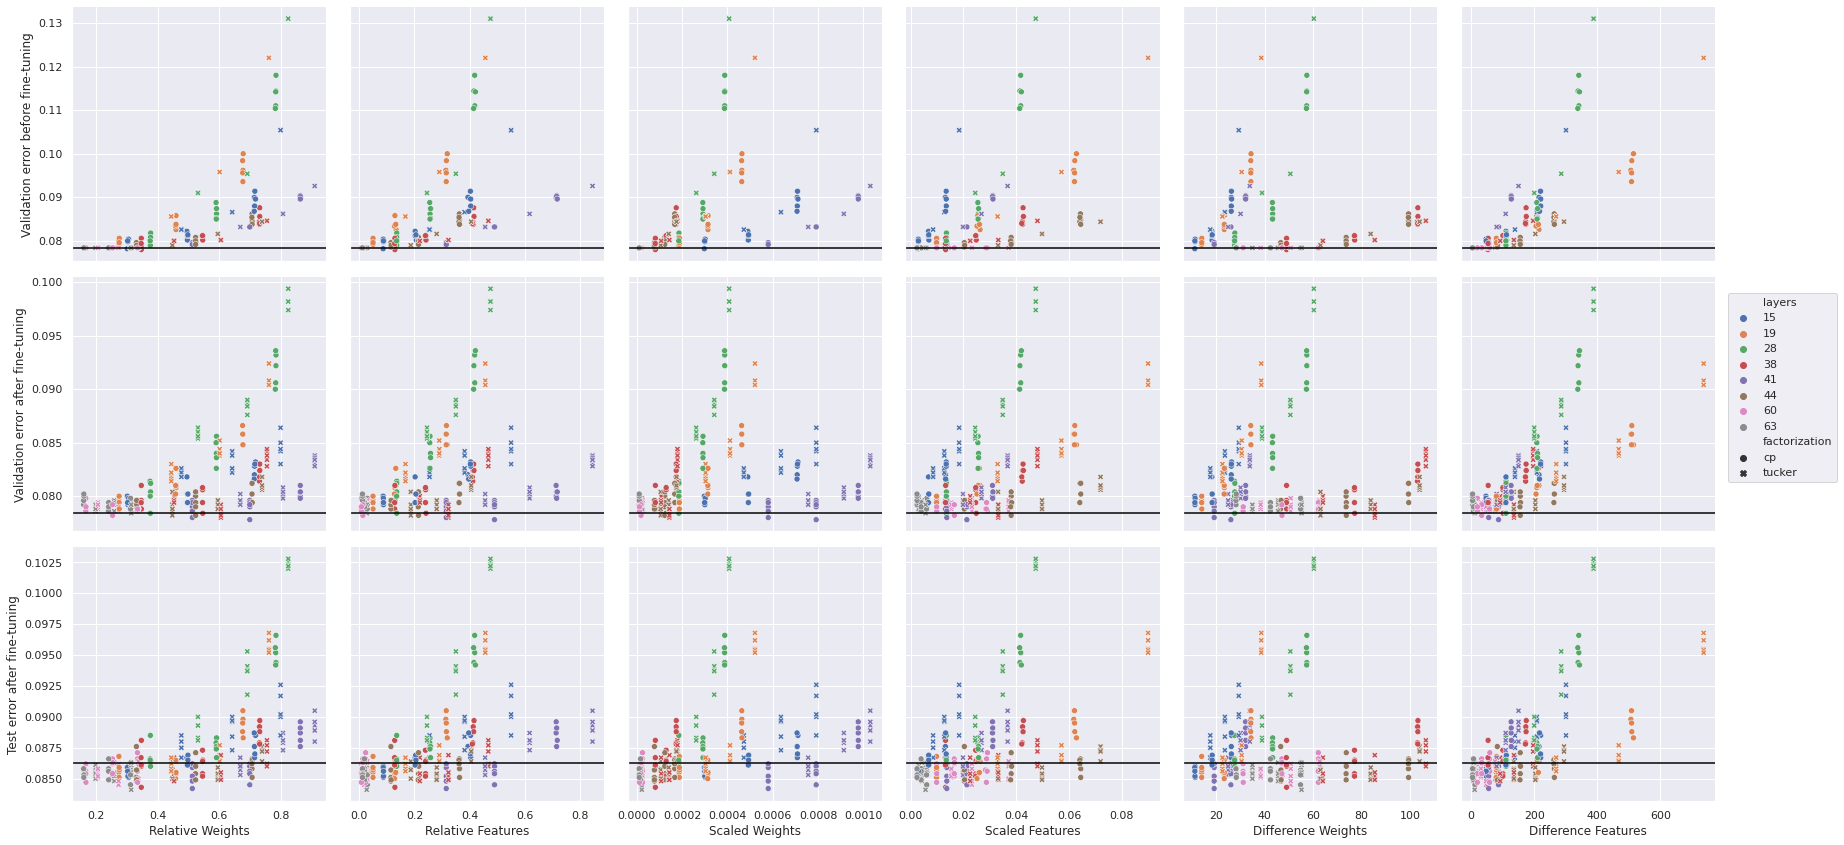

In [49]:
from matplotlib import pyplot as plt 

metrics=['valid_error_before_ft','valid_error','test_error']
log_metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

g = sns.PairGrid(
    df,
    y_vars=metrics, 
    x_vars=errors, # "error"
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
# g.set(ylim=(0.86,0.925))
g.add_legend()

def error(accuracy):
    return 1-accuracy

def log_error(accuracy):
    return np.log(1-accuracy)

lines = {
    0: {
        "y":error(baseline_result['best_valid_acc']),
        "color":'black',
    },
    1: {
        "y":error(baseline_result['best_valid_acc']),
        "color":'black',
    },
    2: {
        "y":error(baseline_result['test_acc']),
        "color":'black',
    },
}

for i in range(3):
    for j in range(6):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

g.savefig("../../plots/cifar10/rn18/scatter_errors_performances_layers_factorizations")

KeyError: 'error'

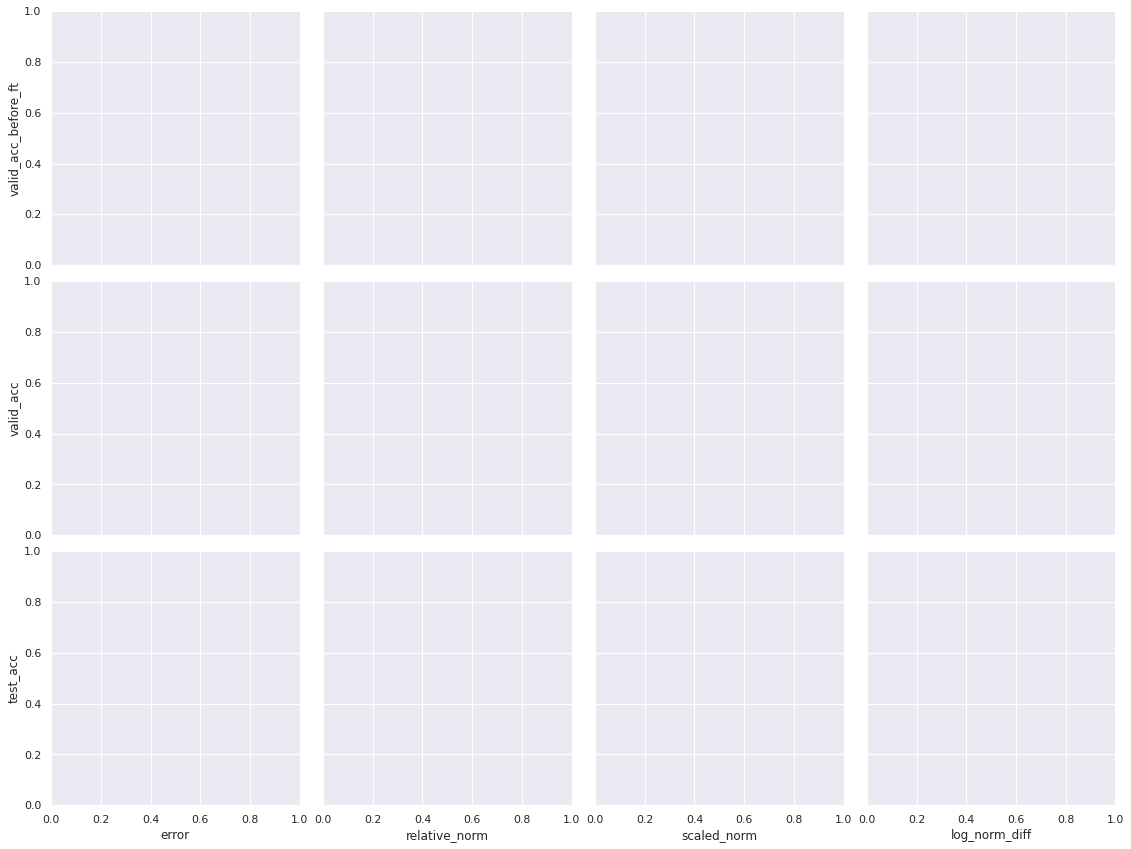

In [37]:
from matplotlib import pyplot as plt 

g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"log_norm_diff"],
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
g.set(ylim=(0.86,0.925))
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

# g.savefig("../../plots/cifar10/rn18/scatter_errors_performances_layers_factorizations")

In [38]:
!pwd

/home/jetzeschuurman/gitProjects/phd/tddl/notebooks/results


KeyError: "['error'] not in index"

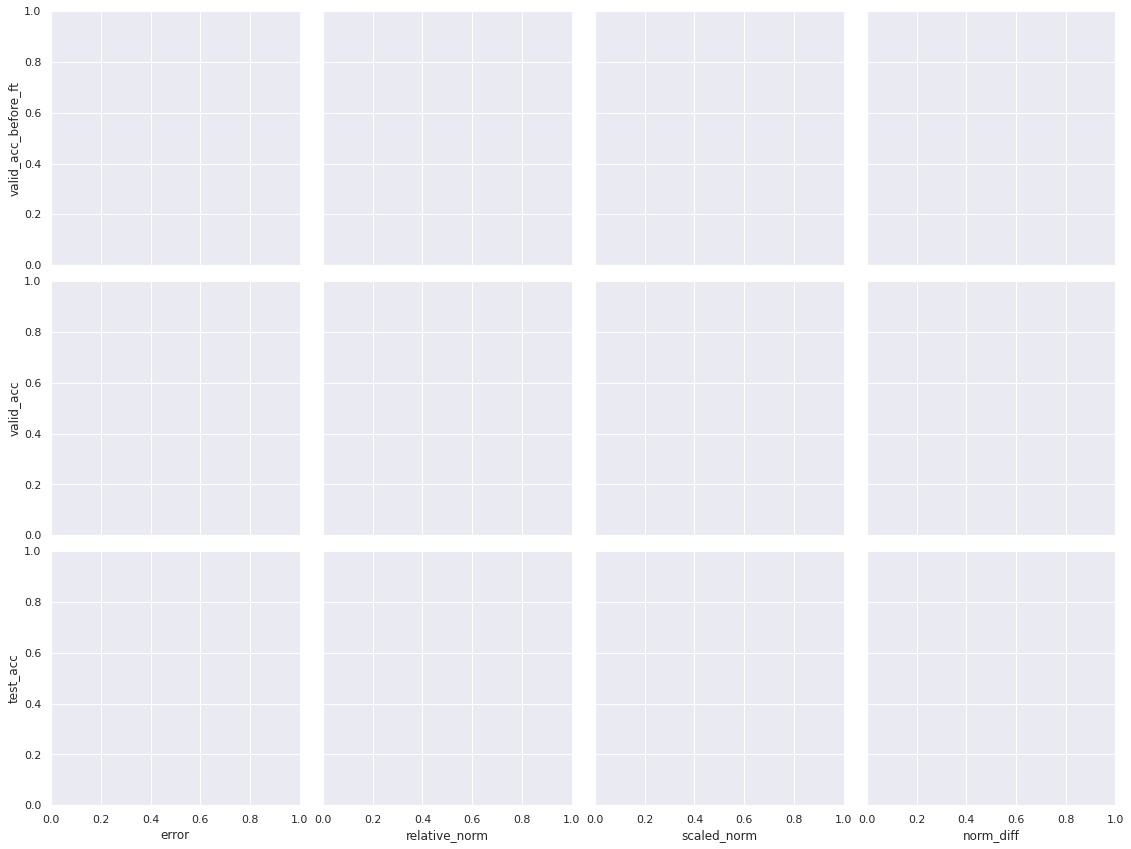

In [39]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="factorization",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

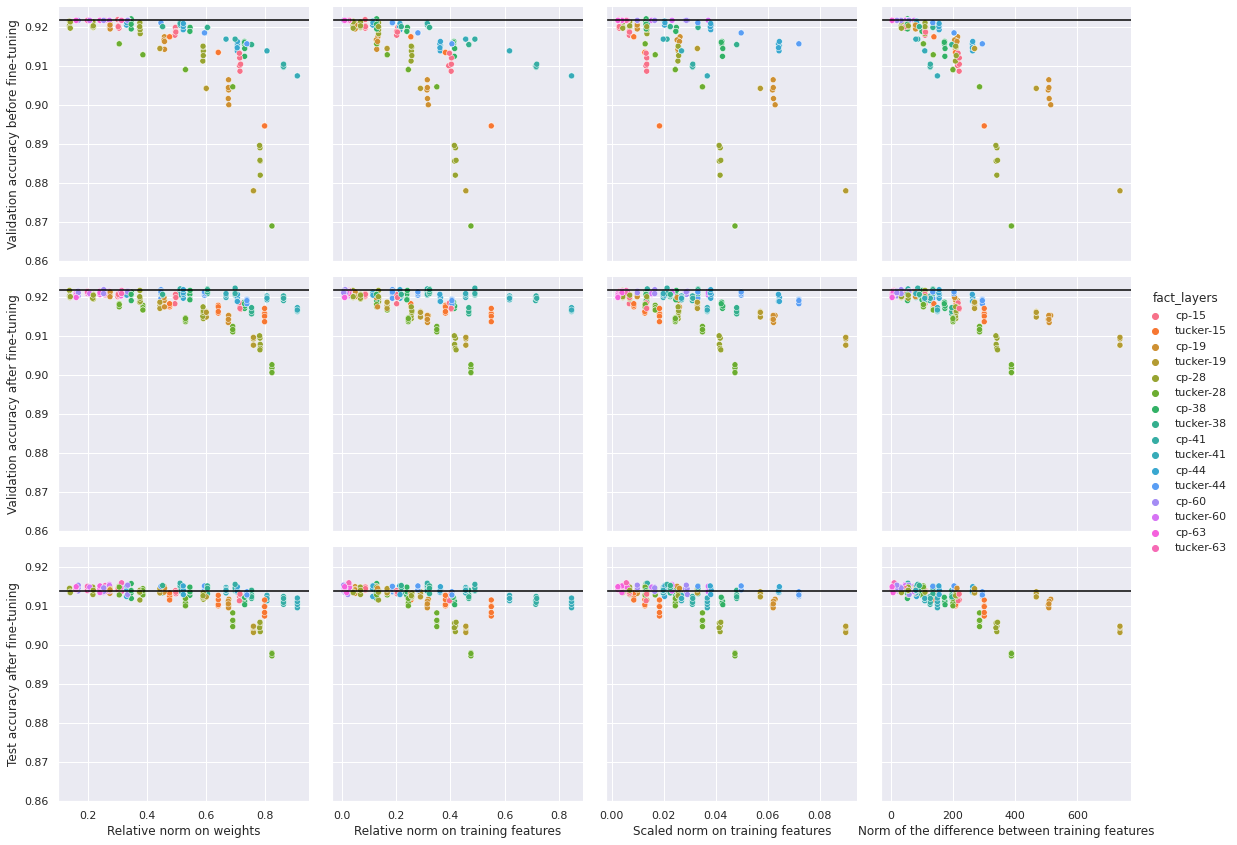

In [89]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="fact_layers",
    height=4,
    hue_order=[
        'cp-15','tucker-15','cp-19','tucker-19','cp-28','tucker-28','cp-38','tucker-38',
        'cp-41','tucker-41','cp-44','tucker-44','cp-60','tucker-60','cp-63','tucker-63',
    ]
    # palette=['b','orange']
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

In [90]:
df

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,...,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact,log_norm_diff,log_test_acc
0,conv2,63,0.311843,63,cp,0.10,0.9210,0.9216,9050765,0.9143,...,12.214946,429.339663,2048.0,0.028521,0.005964,cp-0.1,cp-63,63-cp,2.502660,-0.089597
1,conv1,60,0.337100,60,tucker,0.10,0.9206,0.9216,9051469,0.9137,...,75.989307,2603.942812,2048.0,0.029340,0.037104,tucker-0.1,tucker-60,60-tucker,4.330593,-0.090253
2,conv1,60,0.272814,60,tucker,0.25,0.9210,0.9216,9402829,0.9148,...,47.516211,2603.942812,2048.0,0.018346,0.023201,tucker-0.25,tucker-60,60-tucker,3.861071,-0.089050
3,conv1,28,0.823151,28,tucker,0.10,0.9018,0.8690,11041517,0.8974,...,388.085709,815.280181,8192.0,0.476089,0.047374,tucker-0.1,tucker-28,28-tucker,5.961226,-0.108254
4,conv1,28,0.305965,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,...,105.363881,815.280181,8192.0,0.129281,0.012862,tucker-0.9,tucker-28,28-tucker,4.657420,-0.089378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,conv1,44,0.447319,44,tucker,0.50,0.9212,0.9210,10879741,0.9150,...,135.603151,726.060440,4096.0,0.186951,0.033106,tucker-0.5,tucker-44,44-tucker,4.909733,-0.088831
256,conv2,63,0.160246,63,cp,0.50,0.9198,0.9216,9995161,0.9149,...,4.885679,429.339663,2048.0,0.011455,0.002386,cp-0.5,cp-63,63-cp,1.586308,-0.088941
257,conv2,38,0.452808,38,tucker,0.50,0.9206,0.9200,10879741,0.9152,...,92.270423,420.262521,4096.0,0.219677,0.022527,tucker-0.5,tucker-38,38-tucker,4.524724,-0.088613
258,conv2,15,0.798234,15,tucker,0.10,0.9170,0.8946,11140672,0.9115,...,300.793008,545.957711,16384.0,0.550880,0.018359,tucker-0.1,tucker-15,15-tucker,5.706422,-0.092664


# Kendals tau

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

In [27]:
def p_to_asterisks(p):
    """
    Estimates are significantly different from zero at 1\% significance level, 
    unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), 
    or not significantly different from zero (***).
    """
    if p < 0.01:
        asterisk = ""
    elif p < 0.05:
        asterisk = "*"
    elif p < 0.1:
        asterisk = "**"
    else:
        asterisk = "***"
    return asterisk

In [28]:
from scipy.stats.mstats_basic import kendalltau
from functools import partial

kendalltau_a = partial(kendalltau, use_ties=False, use_missing=False, method='auto')
# kendalltau(x, y, use_ties=True, use_missing=False, method='auto')

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

# TODO: make multilevel columns 
# https://stackoverflow.com/questions/21443963/pandas-multilevel-column-names


metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff','layers']
# errors = ['relative_norm_weight','scaled_norm_weight','diff_norm_weight', 'relative_norm','scaled_norm','norm_diff','layers']
# metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_kt = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = kendalltau_a(df[error], df[metric])
        df_kt[error][metric] = "{:.2f}{}".format(corr,p_to_asterisks(p))


In [29]:

# df_kt.to_pickle("./tables/kt_rn18_c10_classification_error.zip")

In [30]:
# from scipy.stats import kendalltau

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

# TODO: make multilevel columns 
# https://stackoverflow.com/questions/21443963/pandas-multilevel-column-names

# errors = ['error', 'relative_norm','scaled_norm','norm_diff']
# metrics = ['valid_acc_before_ft','valid_acc','test_acc']

# columns = []
# for error in errors:
#     columns.append(f'{error}_tau')
#     columns.append(f'{error}_p')

# df_kt = pd.DataFrame(index=metrics, columns=errors)

# for error in errors:
#     for metric in metrics:
#         corr, p = kendalltau(df[error], df[metric])
#         df_kt[f'{error}_tau'][metric] = corr
#         df_kt[f'{error}_p'][metric] = p

In [31]:
# df_kt.to_pickle("./tables/kt_rn18_c10.zip")

In [32]:
neat_table_indices = {
    'valid_acc_before_ft': "Val. before f.t.",
    'valid_acc': "Val. after f.t.",
    'test_acc': "Test after f.t.",
}
neat_table_columns = {
    'error': "Relative-weights",
    'relative_norm': "Relative-features",
    'scaled_norm': "Scaled-features",
    'norm_diff': "Absolute-features"}
df_kt.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)
df_kt

,relative_norm_weight,Relative-features,scaled_norm_weight,Scaled-features,diff_norm_weight,Absolute-features,layers
log_valid_error_before_ft,0.66,0.63,0.61,0.41,-0.00***,0.69,-0.50
log_valid_error,0.45,0.42,0.41,0.29,-0.03***,0.57,-0.43
log_test_error,0.46,0.43,0.39,0.26,-0.02***,0.46,-0.34


In [33]:
print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='kt_rn18_c10_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{kt_rn18_c10_errors_performances}
\begin{tabular}{llllllll}
\toprule
{} & relative\_norm\_weight & Relative-features & scaled\_norm\_weight & Scaled-features & diff\_norm\_weight & Absolute-features & layers \\
\midrule
log\_valid\_error\_before\_ft &                 0.66 &              0.63 &               0.61 &            0.41 &         -0.00*** &              0.69 &  -0.50 \\
log\_valid\_error           &                 0.45 &              0.42 &               0.41 &            0.29 &     

In [34]:
df.layers.astype(str).unique()

array(['63', '60', '28', '44', '15', '38', '41', '19'], dtype=object)

In [35]:
errors_metrics = []

for error in errors:
    for metric in metrics:
        errors_metrics.append(f'{error}-{metric}')

layers = ['15','19','28','38','41','44','60','63']

df_kt_layers = pd.DataFrame(
    index=errors_metrics,
    columns=layers,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau_a(df_layer[error], df_layer[metric])
            df_kt_layers[str(layer)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))
    

In [36]:
neat_table_indices_layers = {
    'error-valid_acc_before_ft': "Val. before f.t.-weight",
    'error-valid_acc': "Val. after f.t.-weight",
    'error-test_acc': "Test after f.t.-weight",

    'relative_norm-valid_acc_before_ft': "Val. before f.t.-rel. feat.",
    'relative_norm-valid_acc': "Val. after f.t.-rel. feat.",
    'relative_norm-test_acc': "Test after f.t.-rel. feat.",

    'scaled_norm-valid_acc_before_ft': "Val. before f.t.-sc. feat",
    'scaled_norm-valid_acc': "Val. after f.t.-sc. feat",
    'scaled_norm-test_acc': "Test after f.t.-sc. feat",

    'norm_diff-valid_acc_before_ft': "Val. before f.t.-diff. feat",
    'norm_diff-valid_acc': "Val. after f.t.-diff. feat",
    'norm_diff-test_acc': "Test after f.t.-diff. feat",
}

df_kt_layers.rename(index=neat_table_indices_layers, inplace=True)
df_kt_layers

,15,19,28,38,41,44,60,63
relative_norm_weight-log_valid_error_before_ft,0.77,0.75,0.77,0.67,0.81,0.72,0.00***,0.00***
relative_norm_weight-log_valid_error,0.59,0.75,0.76,0.41,0.64,0.44,0.02***,-0.14***
relative_norm_weight-log_test_error,0.55,0.63,0.70,0.29*,0.62,0.32*,0.07***,-0.05***
relative_norm-log_valid_error_before_ft,0.84,0.81,0.77,0.66,0.82,0.75,0.00***,0.00***
relative_norm-log_valid_error,0.69,0.84,0.78,0.40,0.61,0.41,-0.02***,-0.16***
relative_norm-log_test_error,0.65,0.71,0.70,0.31*,0.65,0.31*,0.10***,-0.05***
scaled_norm_weight-log_valid_error_before_ft,0.77,0.75,0.77,0.67,0.81,0.72,0.00***,0.00***
scaled_norm_weight-log_valid_error,0.59,0.75,0.76,0.41,0.64,0.44,0.02***,-0.14***
scaled_norm_weight-log_test_error,0.55,0.63,0.70,0.29*,0.62,0.32*,0.08***,-0.05***
scaled_norm-log_valid_error_before_ft,0.84,0.81,0.77,0.66,0.82,0.75,0.00***,0.00***


In [37]:
print(df_kt_layers.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10 conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='kt_rn18_c10_errors_performances_layers',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10 conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{kt_rn18_c10_errors_performances_layers}
\begin{tabular}{lllllllll}
\toprule
{} &       15 &       19 &       28 &       38 &       41 &       44 &        60 &        63 \\
\midrule
relative\_norm\_weight-log\_valid\_error\_before\_ft &     0.77 &     0.75 &     0.77 &     0.67 &     0.81 &     0.72 &   0.00*** 

In [38]:
df.factorization.unique()

array(['cp', 'tucker'], dtype=object)

In [39]:
factorizations = ['cp', 'tucker']

df_kt_factorizations = pd.DataFrame(
    index=errors_metrics,
    columns=factorizations,
)

for fact in df.factorization.unique():
    df_ = df[df.factorization==fact]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau_a(df_[error], df_[metric])
            df_kt_factorizations[str(fact)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))

df_kt_factorizations.rename(index=neat_table_indices_layers, inplace=True)

print(df_kt_factorizations.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='kt_rn18_c10_errors_performances_factorization',
))
    

\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{kt_rn18_c10_errors_performances_factorization}
\begin{tabular}{lll}
\toprule
{} &       cp &    tucker \\
\midrule
relative\_norm\_weight-log\_valid\_error\_before\_ft &     0.66 &      0.63 \\
relative\_norm\_weight-log\_valid\_error           &     0.42 &      0.47 \\
relative\_norm\_weight-log\_test\

## Mean and std

In [71]:
metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

In [72]:
from tddl.post_processing.kendalls_tau import split_into_run, calculate_kendalls_tau_per_run, mean_std_over_runs

dfs = split_into_run(df, 5)
df_kts = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
df_kt_mean_std = mean_std_over_runs(df_kts, errors=errors, metrics=metrics)
df_kt_mean_std

,relative_norm_weight,relative_norm,scaled_norm_weight,scaled_norm,diff_norm_weight,norm_diff
log_valid_error_before_ft,0.67±0.01,0.64±0.01,0.62±0.02,0.42±0.01,-0.00±0.01,0.71±0.00
log_valid_error,0.46±0.03,0.43±0.03,0.41±0.02,0.30±0.04,-0.04±0.02,0.58±0.04
log_test_error,0.47±0.03,0.43±0.04,0.40±0.04,0.27±0.05,-0.01±0.03,0.46±0.04


In [73]:
from tddl.post_processing.kendalls_tau import mean_over_runs

meh = pd.DataFrame(mean_over_runs(df_kts), index=metrics, columns=errors)

neat_table_indices = {
    'log_valid_error_before_ft': "V B",
    'log_valid_error': "V A",
    'log_test_error': "T A",
}
neat_table_columns = {				
    "relative_norm_weight": "RW",
    "scaled_norm_weight": "SW",
    "diff_norm_weight": "DW",
    "relative_norm": "RF",
    "scaled_norm": "SF",
    "norm_diff": "DF",
    "layers": "L"
}

meh.rename(index=neat_table_indices ,columns=neat_table_columns, inplace=True)
kt = meh.round(decimals=2)

print(kt.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10. Kendall's tau is calculated per run, then averaged over all runs.",
    label='kt_rn18_c10_errors_performances_layers',
))


\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10. Kendall's tau is calculated per run, then averaged over all runs.}
\label{kt_rn18_c10_errors_performances_layers}
\begin{tabular}{lrrrrrr}
\toprule
{} &    RW &    RF &    SW &    SF &    DW &    DF \\
\midrule
V B &  0.67 &  0.64 &  0.62 &  0.42 & -0.00 &  0.71 \\
V A &  0.46 &  0.43 &  0.41 &  0.30 & -0.04 &  0.58 \\
T A &  0.47 &  0.43 &  0.40 &  0.27 & -0.01 &  0.46 \\
\bottomrule
\end{tabular}
\end{table}



In [43]:
from tddl.post_processing.kendalls_tau import dfs_for_bar

df_bar = dfs_for_bar(
    df_kts, 
    dataset='CIFAR-10', 
    model='ResNet-18', 
    errors=errors, 
    metrics=metrics,
)
df_bar.to_pickle("./tables/kta_rn18_c10_bar_log_error.zip")

In [44]:
df_bar

,kt,acc_type,approx_type,dataset,model
0,0.676192,log_valid_error_before_ft,relative_norm_weight,CIFAR-10,ResNet-18
1,0.468102,log_valid_error,relative_norm_weight,CIFAR-10,ResNet-18
2,0.455779,log_test_error,relative_norm_weight,CIFAR-10,ResNet-18
3,0.645039,log_valid_error_before_ft,relative_norm,CIFAR-10,ResNet-18
4,0.421291,log_valid_error,relative_norm,CIFAR-10,ResNet-18
...,...,...,...,...,...
13,-0.010862,log_valid_error,diff_norm_weight,CIFAR-10,ResNet-18
14,0.015241,log_test_error,diff_norm_weight,CIFAR-10,ResNet-18
15,0.734391,log_valid_error_before_ft,norm_diff,CIFAR-10,ResNet-18
16,0.617328,log_valid_error,norm_diff,CIFAR-10,ResNet-18


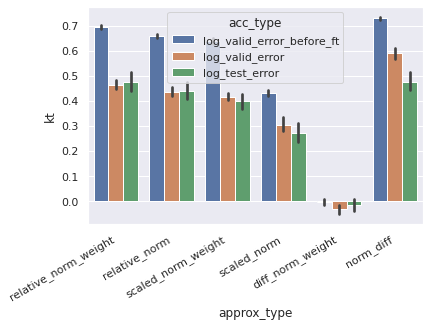

In [45]:
# sns.set_theme(style="whitegrid")

ax = sns.barplot(
    x='approx_type',
    y='kt',
    hue='acc_type',
    data=df_bar,
    # ci="sd", palette="dark", alpha=.6, height=6,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, fontdict={'horizontalalignment':'right'})# 'center', 'left', 'right')

# g.despine(left=True)
# g.set_axis_labels("", "Body mass (g)")
# g.legend.set_title("")

fig = ax.get_figure()
# fig.savefig("../../plots/cifar10/rn18/bar_approx_perform")


In [46]:
# df_kt_mean_std.to_pickle("./tables/kt_rn18_c10_mean_std.zip")

## Kendalls tau per layer

In [47]:
df['layers'].unique()

[63, 60, 28, 44, 15, 38, 41, 19]
Categories (8, int64): [63, 60, 28, 44, 15, 38, 41, 19]

In [70]:
# from scipy.stats import kendalltau
dfs = split_into_run(df, 5)
# n = 0
# layer = 63
model = 'ResNet-18'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error']
approxs = ['relative_norm_weight','relative_norm'] # ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
layers = [15,19,28,38,41,44,60,63]
N = 5

df_layers_ = pd.DataFrame(columns=['kt','layer', 'run', 'performance_metric', 'approximation_error','model','dataset'])
df_means = pd.DataFrame(columns=approxs, index=performs)

array = np.zeros((len(performs),len(approxs),len(layers),N))

for p, perform in enumerate(performs):
    print(perform)
    for a, approx in enumerate(approxs):
        print(approx)
        arr = np.zeros((len(layers),N))
        for l, layer in enumerate(layers):
            for n in range(N):
                df_n = dfs[n]
                df_n_l = df_n.loc[df_n.layers == layer]
                # print(df_n_l)
                c, _ = kendalltau_a(df_n_l[perform],df_n_l[approx])
                print(f"Layer: {layer}, run: {n}, Kendall's tau {c}")
                df_layers_ = df_layers_.append({
                    'layer':layer,
                    'run':n,
                    'performance_metric':perform,
                    'approximation_error':approx,
                    'kt': c,
                    'model': model,
                    'dataset': dataset,
                }, ignore_index=True)
                array[p, a, l, n] = c
                arr[l,n] = c 
        df_means[approx][perform] = arr.mean()

df_layers_.to_pickle("./tables/kta_rn18_c10_bar_log_error_layers.zip")

log_valid_error_before_ft
relative_norm_weight
Layer: 15, run: 0, Kendall's tau 0.8666666666666667
Layer: 15, run: 1, Kendall's tau 0.8666666666666667
Layer: 15, run: 2, Kendall's tau 0.8666666666666667
Layer: 15, run: 3, Kendall's tau 0.8666666666666667
Layer: 15, run: 4, Kendall's tau 0.8666666666666667
Layer: 19, run: 0, Kendall's tau 0.8666666666666667
Layer: 19, run: 1, Kendall's tau 0.7333333333333333
Layer: 19, run: 2, Kendall's tau 0.8666666666666667
Layer: 19, run: 3, Kendall's tau 0.8666666666666667
Layer: 19, run: 4, Kendall's tau 0.8666666666666667
Layer: 28, run: 0, Kendall's tau 0.8666666666666667
Layer: 28, run: 1, Kendall's tau 0.8666666666666667
Layer: 28, run: 2, Kendall's tau 0.8666666666666667
Layer: 28, run: 3, Kendall's tau 0.8666666666666667
Layer: 28, run: 4, Kendall's tau 0.8666666666666667
Layer: 38, run: 0, Kendall's tau 0.8666666666666667
Layer: 38, run: 1, Kendall's tau 0.7333333333333333
Layer: 38, run: 2, Kendall's tau 0.8666666666666667
Layer: 38, run: 3

In [51]:
perform = 'valid_error_before_ft'
approx = 'relative_norm_weight' # ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

In [52]:
df_n_l[perform]

47     0.0784
183    0.0784
144    0.0784
42     0.0784
96     0.0784
157    0.0784
Name: valid_error_before_ft, dtype: float64

In [53]:
df_n_l[approx]

47     0.311712
183    0.240487
144    0.159904
42     0.313901
96     0.258644
157    0.198279
Name: relative_norm_weight, dtype: float64

In [54]:
array

array([[[[ 0.86666667,  0.86666667,  0.86666667,  0.86666667,
           0.86666667],
         [ 0.86666667,  0.86666667,  0.86666667,  0.73333333,
           0.86666667],
         [ 0.86666667,  0.86666667,  0.86666667,  0.86666667,
           0.86666667],
         [ 0.93333333,  0.86666667,  0.6       ,  0.73333333,
           0.73333333],
         [ 0.93333333,  0.93333333,  0.93333333,  0.93333333,
           0.93333333],
         [ 0.86666667,  0.8       ,  0.73333333,  0.93333333,
           1.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ]],

        [[ 1.        ,  1.        ,  1.        ,  1.        ,
           1.        ],
         [ 0.73333333,  1.        ,  1.        ,  0.86666667,
           1.        ],
         [ 0.86666667,  0.86666667,  0.86666667,  0.86666667,
           0.86666667],
         [ 0.93333333,  0.86666667,  0.6       ,  0.

In [55]:
array_masked = np.ma.array(array, mask=np.isnan(array))

In [56]:
array_masked_mean = array_masked.mean(axis=(2,3))

In [57]:
pd.DataFrame(data=array_masked_mean, columns=approxs, index=performs)

,relative_norm_weight,relative_norm
log_valid_error_before_ft,0.643333,0.670000
log_valid_error,0.503333,0.546667
log_test_error,0.481667,0.498333


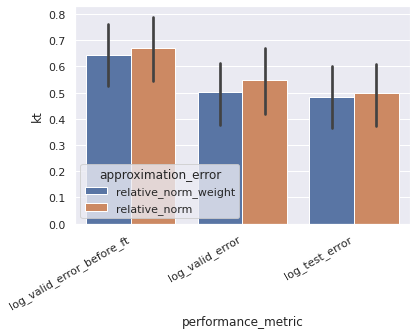

In [58]:
ax = sns.barplot(
    x='performance_metric',
    y='kt',
    hue='approximation_error',
    data=df_layers_,
    # ci="sd", palette="dark", alpha=.6, height=6,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, fontdict={'horizontalalignment':'right'})# 'center', 'left', 'right')
fig = ax.get_figure()

In [59]:
df_layers_.groupby(['approximation_error','performance_metric',]).mean()

kt
approximation_error  performance_metric                 
relative_norm        log_test_error             0.498333
                     log_valid_error            0.546667
                     log_valid_error_before_ft  0.670000
relative_norm_weight log_test_error             0.481667
                     log_valid_error            0.503333
                     log_valid_error_before_ft  0.643333

In [60]:
from tddl.post_processing.kendalls_tau import split_into_layers, mean_over_runs, df_for_bar

metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

dfs_layers = split_into_layers(df, 'nr')

df_kts_layers = calculate_kendalls_tau_per_run(dfs_layers, errors=errors, metrics=metrics)
# df_kts_layers_bar = df_for_bar(
#     df_kts_layers,     
#     dataset='CIFAR-10', 
#     model='ResNet-18', 
#     errors=errors, 
#     metrics=metrics,
# )
# df_kts_layers_bar.to_pickle("./tables/kt_rn18_c10_bar_error_layers.zip")

df_kt_layers_mean = pd.DataFrame(mean_over_runs(df_kts), index=metrics, columns=errors)

# dfs = split_into_run(df, 5)
# df_kts = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
# df_kt_mean_std = mean_std_over_runs(df_kts, errors=errors, metrics=metrics)
# df_kt_mean_std

In [61]:
dfs_layers[0]
dfs_0 = split_into_run(dfs_layers[0], 5)
dfl_kts_0 = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
df_kt_layers_means_0 = pd.DataFrame(mean_over_runs(dfl_kts_0), index=metrics, columns=errors)
df_kt_layer_mean_0 = pd.DataFrame(mean_over_runs([df_kt_layers_means_0]), index=metrics, columns=errors)

In [62]:
df_kt_layers_means_0

,relative_norm_weight,relative_norm,scaled_norm_weight,scaled_norm,diff_norm_weight,norm_diff
log_valid_error_before_ft,0.692335,0.658975,0.639910,0.429843,-0.003481,0.728259
log_valid_error,0.462083,0.436108,0.422693,0.305682,-0.041295,0.601054
log_test_error,0.482040,0.446994,0.406933,0.270952,-0.020953,0.474118


In [63]:
dfs[0]

,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,...,scaled_norm,test_error,valid_error_before_ft,valid_error,log_test_error,log_valid_error_before_ft,log_valid_error,fact_rank,fact_layers,layers_fact
188,conv2,15,0.712867,0.000708,26.083843,15,cp,0.10,0.9184,0.9132,...,0.013236,0.0887,0.0868,0.0816,-2.422495,-2.444149,-2.505926,cp-0.1,cp-15,15-cp
170,conv2,15,0.497974,0.000494,18.220913,15,cp,0.25,0.9198,0.9188,...,0.006826,0.0869,0.0812,0.0802,-2.442997,-2.510840,-2.523232,cp-0.25,cp-15,15-cp
22,conv2,15,0.301261,0.000299,11.023141,15,cp,0.50,0.9200,0.9218,...,0.002887,0.0859,0.0782,0.0800,-2.454571,-2.548486,-2.525729,cp-0.5,cp-15,15-cp
78,conv2,15,0.798234,0.000792,29.207430,15,tucker,0.10,0.9150,0.8946,...,0.018359,0.0926,0.1054,0.0850,-2.379466,-2.249993,-2.465104,tucker-0.1,tucker-15,15-tucker
8,conv2,15,0.641337,0.000637,23.466545,15,tucker,0.25,0.9176,0.9134,...,0.012736,0.0900,0.0866,0.0824,-2.407946,-2.446455,-2.496170,tucker-0.25,tucker-15,15-tucker
123,conv2,15,0.476572,0.000473,17.437807,15,tucker,0.50,0.9182,0.9174,...,0.008494,0.0867,0.0826,0.0818,-2.445301,-2.493746,-2.503478,tucker-0.5,tucker-15,15-tucker
173,conv1,19,0.676121,0.000464,34.219364,19,cp,0.10,0.9152,0.9064,...,0.062048,0.0905,0.0936,0.0848,-2.402405,-2.368725,-2.467460,cp-0.1,cp-19,19-cp
81,conv1,19,0.459315,0.000315,23.246534,19,cp,0.25,0.9192,0.9142,...,0.025440,0.0854,0.0858,0.0808,-2.460409,-2.455736,-2.515778,cp-0.25,cp-19,19-cp
182,conv1,19,0.275189,0.000189,13.927707,19,cp,0.50,0.9212,0.9194,...,0.009819,0.0857,0.0806,0.0788,-2.456902,-2.518257,-2.540842,cp-0.5,cp-19,19-cp
174,conv1,19,0.760520,0.000522,38.490913,19,tucker,0.10,0.9076,0.8780,...,0.089941,0.0952,0.1220,0.0924,-2.351775,-2.103734,-2.381628,tucker-0.1,tucker-19,19-tucker


In [64]:
print(dfl_kts[0])

NameError: name 'dfl_kts' is not defined

In [65]:
dfs_layers[0].head()

,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,...,scaled_norm,test_error,valid_error_before_ft,valid_error,log_test_error,log_valid_error_before_ft,log_valid_error,fact_rank,fact_layers,layers_fact
0,conv2,63,0.311843,0.000023,54.784103,63,cp,0.10,0.9210,0.9216,...,0.005964,0.0857,0.0784,0.0790,-2.456902,-2.545931,-2.538307,cp-0.1,cp-63,63-cp
5,conv2,63,0.198279,0.000015,34.833344,63,tucker,0.50,0.9210,0.9216,...,0.003005,0.0855,0.0784,0.0790,-2.459239,-2.545931,-2.538307,tucker-0.5,tucker-63,63-tucker
25,conv2,63,0.258644,0.000019,45.438248,63,tucker,0.25,0.9214,0.9216,...,0.004210,0.0855,0.0784,0.0786,-2.459239,-2.545931,-2.543384,tucker-0.25,tucker-63,63-tucker
41,conv2,63,0.198279,0.000015,34.833344,63,tucker,0.50,0.9214,0.9216,...,0.003005,0.0859,0.0784,0.0786,-2.454571,-2.545931,-2.543384,tucker-0.5,tucker-63,63-tucker
42,conv2,63,0.313901,0.000023,55.145676,63,tucker,0.10,0.9206,0.9216,...,0.005626,0.0861,0.0784,0.0794,-2.452246,-2.545931,-2.533257,tucker-0.1,tucker-63,63-tucker


In [66]:
from tddl.post_processing.kendalls_tau import split_into_layers, mean_over_runs, df_for_bar

metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

dfs_layers = split_into_layers(df, 'nr')

df_kt_layers_means = []
for dfl in dfs_layers:
    dfs = split_into_run(dfl, 5)
    print(len(dfs))
    dfl_kts = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
    df_kt_layers_means.append(
        pd.DataFrame(mean_over_runs(dfl_kts), index=metrics, columns=errors)
    )
df_kt_layer_mean = pd.DataFrame(mean_over_runs(df_kt_layers_means), index=metrics, columns=errors)

df_kt_layer_mean

neat_table_indices = {
    'log_valid_error_before_ft': "V B",
    'log_valid_error': "V A",
    'log_test_error': "T A",
}
neat_table_columns = {				
    "relative_norm_weight": "RW",
    "scaled_norm_weight": "SW",
    "diff_norm_weight": "DW",
    "relative_norm": "RF",
    "scaled_norm": "SF",
    "norm_diff": "DF",
    "layers": "L"
}

df_kt_layers_mean.rename(index=neat_table_indices ,columns=neat_table_columns, inplace=True)
ktl = df_kt_layers_mean.round(decimals=2)

print(ktl.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10. Kendall's tau is calculated per layer per run, then averaged over all layers and runs.",
    label='kt_rn18_c10_errors_performances_layers',
))


5
5
5
5
5
5
5
5
\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10. Kendall's tau is calculated per layer per run, then averaged over all layers and runs.}
\label{kt_rn18_c10_errors_performances_layers}
\begin{tabular}{lrrrrrr}
\toprule
{} &    RW &    RF &    SW &    SF &    DW &    DF \\
\midrule
V B &  0.69 &  0.66 &  0.64 &  0.43 & -0.00 &  0.73 \\
V A &  0.46 &  0.44 &  0.42 &  0.30 & -0.03 &  0.59 \\
T A &  0.48 &  0.44 &  0.40 &  0.27 & -0.01 &  0.48 \\
\bottomrule
\end{tabular}
\end{table}



In [67]:
neat_table_indices = {
    'log_valid_error_before_ft': "V B",
    'log_valid_error': "V A",
    'log_test_error': "T A",
}
neat_table_columns = {				
    "relative_norm_weight": "RW",
    "scaled_norm_weight": "SW",
    "diff_norm_weight": "DW",
    "relative_norm": "RF",
    "scaled_norm": "SF",
    "norm_diff": "DF",
    "layers": "L"
}
df_kt_layers_mean.rename(index=neat_table_indices ,columns=neat_table_columns, inplace=True)
ktl = df_kt_layers_mean.round(decimals=2)

In [68]:
print(ktl.to_latex(
    position='htbp', 
#     caption="
    label='kt_rn18_c10_errors_performances_layers'
))
# print(df_kt_factorizations.to_latex(
#     position='htbp', 
#     caption="Kendall's tau from ResNet18 on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
#     label='kt_rn18_c10_errors_performances_factorization',
# ))

\begin{table}[htbp]
\centering
\label{kt_rn18_c10_errors_performances_layers}
\begin{tabular}{lrrrrrr}
\toprule
{} &    RW &    RF &    SW &    SF &    DW &    DF \\
\midrule
V B &  0.69 &  0.66 &  0.64 &  0.43 & -0.00 &  0.73 \\
V A &  0.46 &  0.44 &  0.42 &  0.30 & -0.03 &  0.59 \\
T A &  0.48 &  0.44 &  0.40 &  0.27 & -0.01 &  0.48 \\
\bottomrule
\end{tabular}
\end{table}



In [69]:
df_kts_layers_bar = df_for_bar(
    df_kts_layers,     
    dataset='CIFAR-10', 
    model='ResNet-18', 
    errors=errors, 
    metrics=metrics,
)
# df_kts_layers_bar.to_pickle("./tables/kt_rn18_c10_bar_error_layers.zip")


TypeError: list indices must be integers or slices, not tuple

# Pearson Correlation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [39]:
from scipy.stats import pearsonr

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_pr = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = pearsonr(df[error], df[metric])
        df_pr[error][metric] = corr

KeyError: 'error'

In [40]:
df_pr.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)

print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Pearson's rho from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='pr_rn18_c10_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Pearson's rho from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{pr_rn18_c10_errors_performances}
\begin{tabular}{llllllll}
\toprule
{} & relative\_norm\_weight & scaled\_norm\_weight & diff\_norm\_weight & Relative-features & Scaled-features & Difference-features & layers \\
\midrule
Val. before f.t. &                -0.63 &              -0.64 &         -0.02*** &             -0.64 &           -0.41 &               -0.71 &   0.53 \\
Val. after f.t.  &                -0.42 &              -0.43 &          0.03*** &             -0.42 &           -0.28 &    

In [41]:
df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

KeyError: 'error'

In [42]:
df_pr_layers

,relative_norm_weight-valid_acc_before_ft,relative_norm_weight-valid_acc,relative_norm_weight-test_acc,scaled_norm_weight-valid_acc_before_ft,scaled_norm_weight-valid_acc,scaled_norm_weight-test_acc,diff_norm_weight-valid_acc_before_ft,diff_norm_weight-valid_acc,diff_norm_weight-test_acc,relative_norm-valid_acc_before_ft,...,relative_norm-test_acc,scaled_norm-valid_acc_before_ft,scaled_norm-valid_acc,scaled_norm-test_acc,norm_diff-valid_acc_before_ft,norm_diff-valid_acc,norm_diff-test_acc,layers-valid_acc_before_ft,layers-valid_acc,layers-test_acc
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


KeyError: 'error'

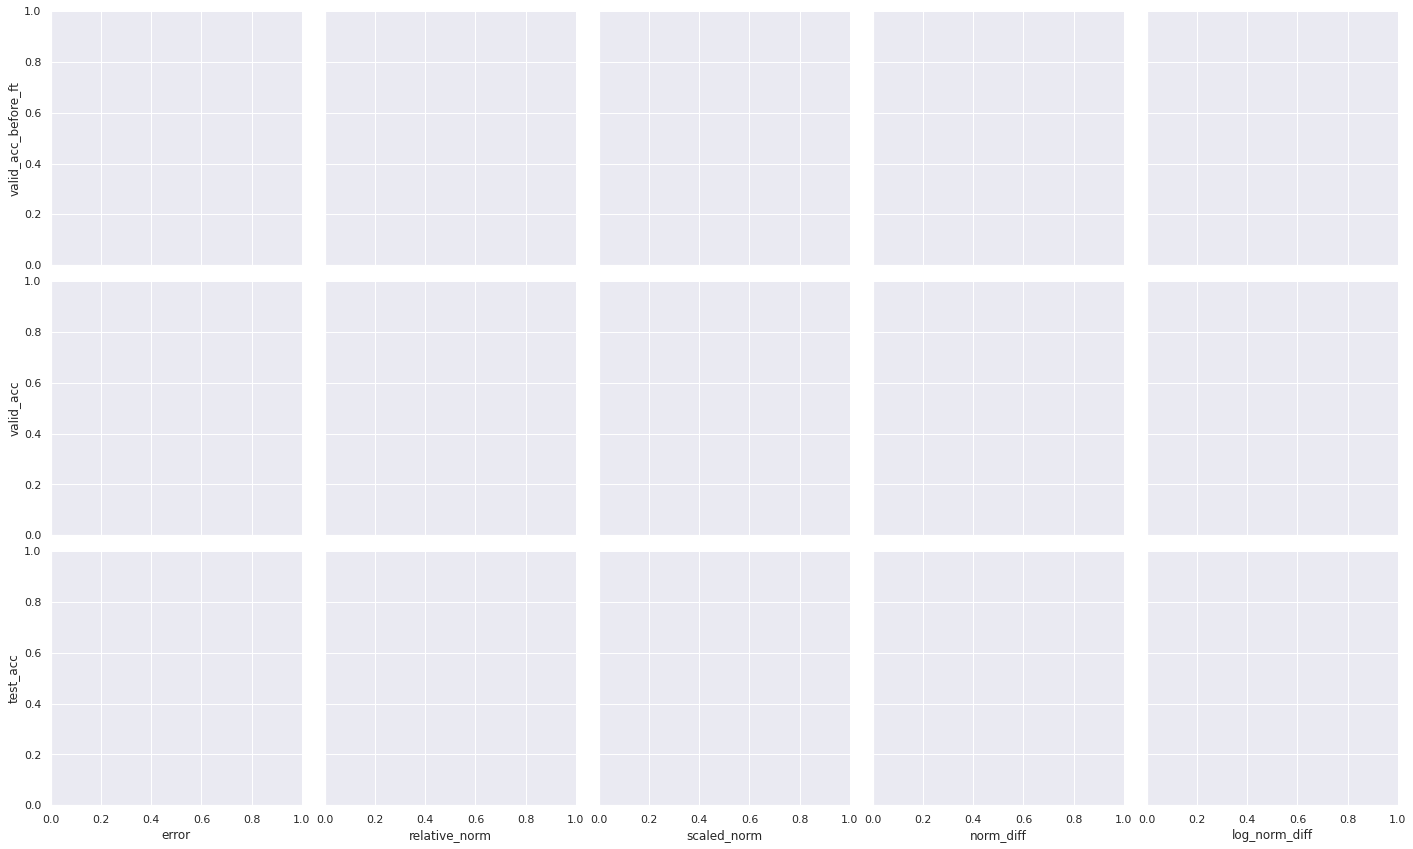

In [43]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm","norm_diff" ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.savefig("../../plots/cifar10/rn18/rn18_c10_linear_errors_performances_layers")

In [111]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'relative_norm_weight': 'Relative Weights',
    'scaled_norm_weight': 'Scaled Weights',
    'diff_norm_weight': 'Absolute Weights',
    'relative_norm': 'Relative Features',
    'scaled_norm': 'Scaled Features',
    'norm_diff': 'Absolute Features',
    'log_valid_error_before_ft': 'Log Validation error before fine-tuning',
    'log_valid_error': 'Log Validation error after fine-tuning',
    'log_test_error': 'Log Test error after fine-tuning'
    # 'log_norm_diff': 'Log norm of the Absolute between training features',
}

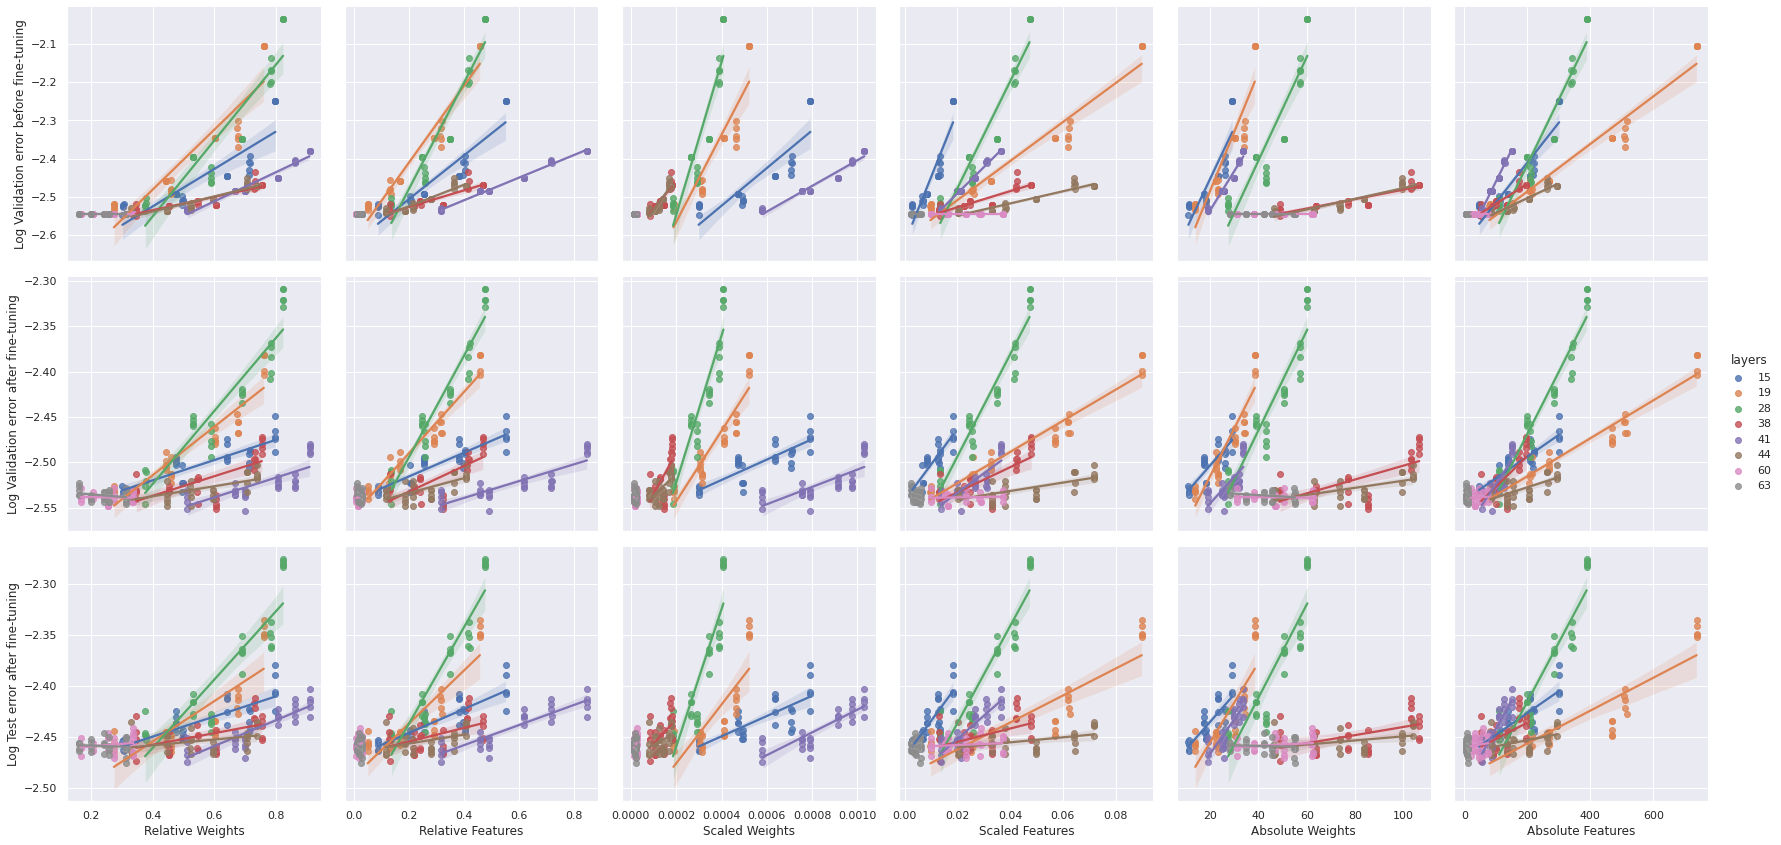

In [112]:
g = sns.PairGrid(
    df,
    y_vars=metrics, # ["valid_error_before_ft", "log_valid_error","log_test_error"], 
    x_vars=errors, # ["relative_norm", "scaled_norm","norm_diff"],# ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
# g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(6):
        gax = g.axes[i][j]
        # gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.savefig("../../plots/cifar10/rn18/rn18_c10_linear_errors_performances_layers")

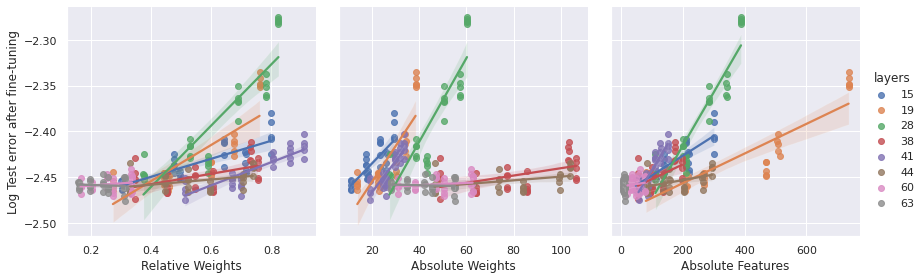

In [113]:
metrics = ['log_test_error']
errors = ["relative_norm_weight", "diff_norm_weight", "norm_diff",]
    # 'relative_norm_weight': 'Relative Weights',
    # 'scaled_norm_weight': 'Scaled Weights',
    # 'diff_norm_weight': 'Absolute Weights',
    # 'relative_norm': 'Relative Features',
    # 'scaled_norm': 'Scaled Features',
    # 'norm_diff': 'Absolute Features',

g = sns.PairGrid(
    df,
    y_vars=metrics, # ["valid_error_before_ft", "log_valid_error","log_test_error"], 
    x_vars=errors, # ["relative_norm", "scaled_norm","norm_diff"],# ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
# g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(1):
    for j in range(3):
        gax = g.axes[i][j]
        # gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.savefig("../../plots/cifar10/rn18/rn18_c10_linear_ltd-approx_test-after-ft_layers")

KeyError: 'error'

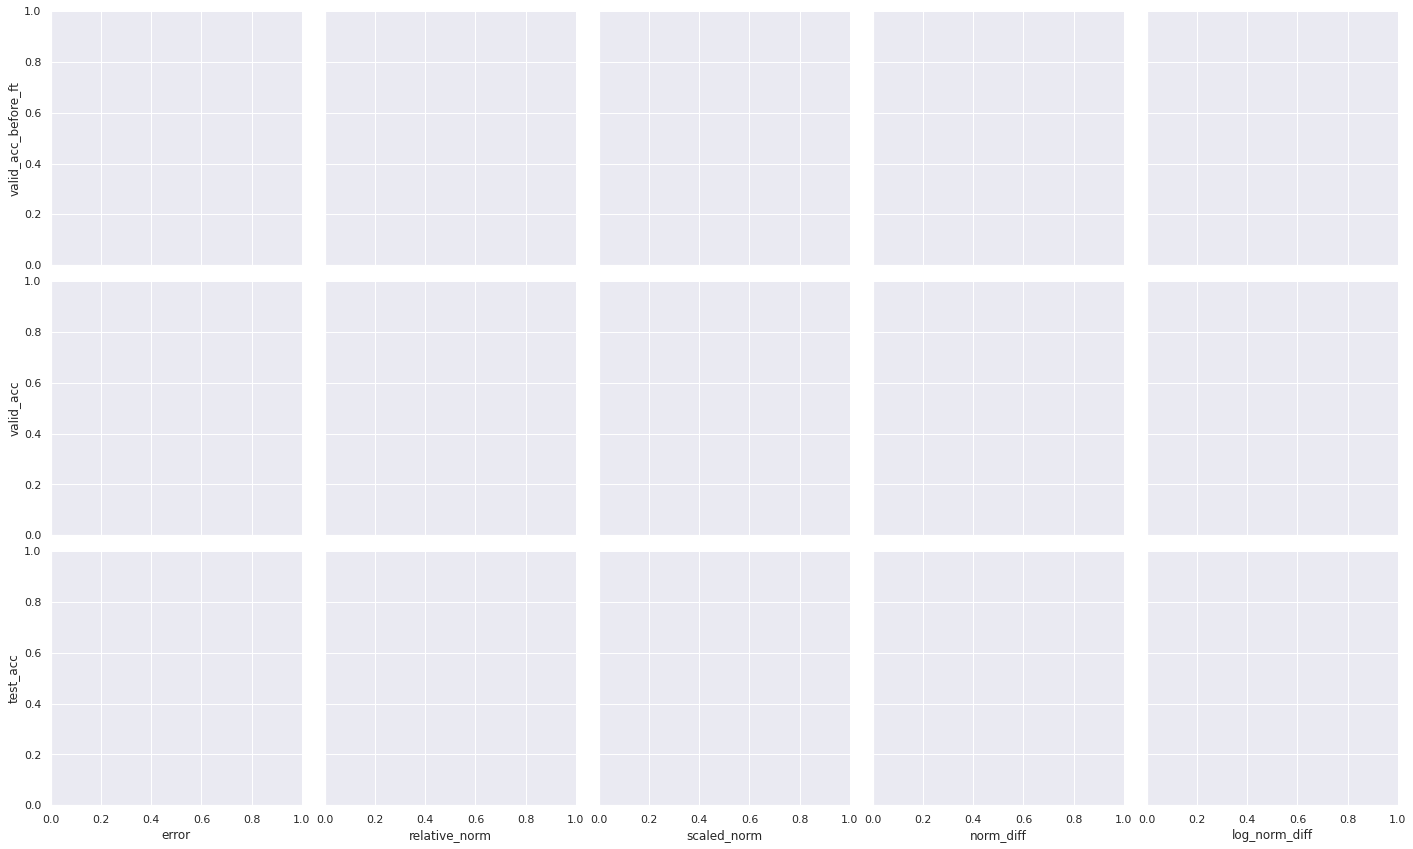

In [44]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff","log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(lambda x, y, **kwargs: sns.regplot(x=x,y=y,order=2)) # sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

# plt.legend(
#     bbox_to_anchor=(1.05, 1,1,1),
#     loc='upper left', borderaxespad=0.
# )
# g.savefig("../../plots/cifar10/rn18/rn18_c10_poly2_errors_performances_layers")

In [45]:
from statsmodels.api import OLS

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_ols = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        res = OLS(df[metric], df[error], hasconst=True).fit()
        print(res.summary())
        # df_kt[error][metric] = (corr, p)

KeyError: 'error'

In [46]:



df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

KeyError: 'error'

In [ ]:
df_pr_layers

,error-valid_acc_before_ft,error-valid_acc,error-test_acc,relative_norm-valid_acc_before_ft,relative_norm-valid_acc,relative_norm-test_acc,scaled_norm-valid_acc_before_ft,scaled_norm-valid_acc,scaled_norm-test_acc,norm_diff-valid_acc_before_ft,norm_diff-valid_acc,norm_diff-test_acc
63,"(nan, nan)","(0.2879151138321128, 0.12286811404521604)","(0.08140949047449081, 0.6688969781722545)","(nan, nan)","(0.22660045854936292, 0.2285339296372333)","(0.08969793863827741, 0.6373750749423998)","(nan, nan)","(0.22549585148419915, 0.23087130977122738)","(0.08987146559723141, 0.6367214748520443)","(nan, nan)","(0.22549585148419915, 0.23087130977122738)","(0.08987146559723141, 0.6367214748520443)"
60,"(nan, nan)","(0.05364974643058675, 0.7782745727113813)","(-0.202319015036619, 0.28363153595318413)","(nan, nan)","(-0.07591620160216175, 0.6901010135920719)","(-0.13347274372940285, 0.481960786929708)","(nan, nan)","(-0.07619222745748086, 0.6890298881252326)","(-0.1332129890742588, 0.4828216177381716)","(nan, nan)","(-0.07619222745748086, 0.6890298881252326)","(-0.1332129890742588, 0.4828216177381716)"
28,"(-0.8473943846363547, 8.526029318429482e-15)","(-0.89963258051531, 6.749407186012029e-19)","(-0.8503506557583609, 5.521851294743111e-15)","(-0.9120220389779395, 3.2969719058788e-20)","(-0.9501238765400875, 6.183917885757045e-26)","(-0.9094785965290709, 6.345321235786794e-20)","(-0.9120504145735633, 3.272613774020444e-20)","(-0.9501462603759921, 6.119201642748657e-26)","(-0.9095089557688517, 6.296645262386004e-20)","(-0.9120504145735633, 3.272613774020444e-20)","(-0.9501462603759921, 6.119201642748657e-26)","(-0.9095089557688517, 6.296645262386004e-20)"
44,"(-0.92807967008753, 1.5569321880360468e-13)","(-0.6504162560386235, 9.984548200024738e-05)","(-0.40001403206557967, 0.028506973055201903)","(-0.9426384838741954, 7.18649942865184e-15)","(-0.6841285370782828, 3.0657713149688406e-05)","(-0.43789598452890244, 0.015512948579349773)","(-0.9426349991137994, 7.192458046807915e-15)","(-0.684144129964898, 3.0639890645477375e-05)","(-0.4379219058215649, 0.015506136280367542)","(-0.9426349991137994, 7.192458046807915e-15)","(-0.684144129964898, 3.0639890645477375e-05)","(-0.4379219058215649, 0.015506136280367542)"
15,"(-0.8452560604640299, 4.1808353690622275e-09)","(-0.8308757372821841, 1.3206059307718488e-08)","(-0.778557370077811, 4.0628161410152266e-07)","(-0.9041877267765982, 7.42816655433022e-12)","(-0.88880481257465, 5.416616492454828e-11)","(-0.8428099291664479, 5.125140529275926e-09)","(-0.9042329237813166, 7.381372629649023e-12)","(-0.8888088544663618, 5.414000236015289e-11)","(-0.8428153045877268, 5.122866793629805e-09)","(-0.9042329237813166, 7.381372629649023e-12)","(-0.8888088544663618, 5.414000236015289e-11)","(-0.8428153045877268, 5.122866793629805e-09)"
38,"(-0.865389039933643, 6.767629125830957e-10)","(-0.6776279241263408, 3.895111656379433e-05)","(-0.5044203224748514, 0.004476991652362888)","(-0.8635795042211782, 8.064108376976551e-10)","(-0.7167802034754958, 8.35639365741935e-06)","(-0.48123306693167356, 0.007096860612639137)","(-0.8635896750238307, 8.056224123315002e-10)","(-0.7167965316315917, 8.350594812939163e-06)","(-0.48124877796815807, 0.007094720012967866)","(-0.8635896750238307, 8.056224123315002e-10)","(-0.7167965316315917, 8.350594812939163e-06)","(-0.48124877796815807, 0.007094720012967866)"
41,"(-0.9703158826938701, 8.423955171813325e-19)","(-0.7495675516016722, 1.8693704254260377e-06)","(-0.8643378889684963, 7.495257969083912e-10)","(-0.9941407242821838, 1.3281946044565624e-28)","(-0.8424403179898148, 5.283717911651034e-09)","(-0.885164202369319, 8.308319981602859e-11)","(-0.9941311159924484, 1.3589347640551856e-28)","(-0.8424757709014247, 5.2683145963633854e-09)","(-0.8851908100070819, 8.282817723520555e-11)","(-0.9941311159924484, 1.3589347640551856e-28)","(-0.8424757709014247, 5.2683145963633854e-09)","(-0.8851908100070819, 8.282817723520555e-11)"
19,"(-0.8860065078609245, 7.535093163088947e-11)","(-0.91120302739687